# Training and analysis script for ViT Classifier of PIScO Plankton images
Version: 250611


In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"

import torch
import numpy as np
from datasets import load_dataset, DatasetDict, ClassLabel#, load_metric
from datasets import Dataset, Features, Image as ImageFeature, Value, concatenate_datasets
from PIL import Image
import torchvision.transforms as transforms
from transformers import AutoImageProcessor
import torchvision.transforms.functional as F
from transformers import Trainer
import evaluate
from transformers import TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict

import matplotlib.pyplot as plt
import random
from transformers import AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd
import logging


## Core Functions

In [47]:
def merge_datasets(dataset_paths, output_dir="merged_dataset"):
    """
    Merge multiple image datasets while handling scale bars into a permanent directory.
    
    Args:
        dataset_paths (dict): Dictionary with dataset paths as keys and scale bar flags as values
            Example: {'/path/to/dataset1': True, '/path/to/dataset2': False}
        output_dir (str): Path where the merged dataset will be stored
    
    Returns:
        datasets.Dataset: Merged dataset
    """
    import os
    from PIL import Image
    from datasets import load_dataset
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each dataset
    for dataset_path, has_scale_bar in dataset_paths.items():
        print(f"Processing dataset: {dataset_path}")
        # Iterate through all class directories in the source dataset
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            
            # Skip if not a directory
            if not os.path.isdir(class_path):
                continue
            
            # Create corresponding class directory in output folder
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)
            print(f"Processing class: {class_name}")
            
            # Process each image in the class directory
            for img_name in os.listdir(class_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
                    continue
                    
                img_path = os.path.join(class_path, img_name)
                output_path = os.path.join(output_class_path, img_name)
                
                # Skip if image already exists in output directory
                if os.path.exists(output_path):
                    continue
                
                try:
                    # Open and process image
                    with Image.open(img_path) as img:
                        # Convert to RGB if necessary
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        
                        # Remove scale bar if needed
                        if has_scale_bar:
                            width, height = img.size
                            img = img.crop((0, 0, width, height - 50))
                        
                        # Save processed image to output directory
                        img.save(output_path)
                        
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    continue
    
    print(f"\nMerged dataset saved to: {output_dir}")
    # Load the merged dataset using datasets library
    merged_dataset = load_dataset("imagefolder", data_dir=output_dir)
    
    return merged_dataset['train']

In [27]:
def visualize_transformations(dataset, original_ds, num_samples=25, rows=5, cols=5):
    # Randomly sample indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and transformed version
        original = original_ds[sample_idx]
        transformed = dataset[sample_idx]
        
        label = original_ds.features['label'].names[original['label']]
        
        # Original image
        plt.subplot(rows, cols*2, idx*2 + 1)
        plt.imshow(original['image'])
        plt.title(f'Original\n{label}', fontsize=8)
        plt.axis('off')
        
        # Transformed image
        plt.subplot(rows, cols*2, idx*2 + 2)
        # Convert tensor to numpy and adjust for display
        transformed_img = transformed['pixel_values'].permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(transformed_img)
        plt.title('Transformed', fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_label_distribution(dataset, title="Label Distribution"):
    # Count labels
    label_counts = Counter(dataset['label'])
    
    # Convert to percentages
    total_samples = len(dataset)
    label_percentages = {dataset.features['label'].names[k]: (v/total_samples)*100 
                        for k, v in label_counts.items()}
    
    # Sort by frequency
    sorted_items = sorted(label_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, values = zip(*sorted_items)
    
    # Create figure with sufficient height for labels
    plt.figure(figsize=(15, 8))
    
    # Create bar plot
    bars = plt.bar(labels, values)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage of Dataset (%)')
    plt.title(title)
    
    # Add percentage values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"\nClass distribution:")
    for label, percentage in sorted_items:
        count = int(percentage * total_samples / 100)
        print(f"{label}: {count} samples ({percentage:.1f}%)")
    
    # Calculate imbalance ratio (majority:minority)
    max_samples = max(label_counts.values())
    min_samples = min(label_counts.values())
    imbalance_ratio = max_samples / min_samples
    print(f"\nImbalance ratio (majority:minority): {imbalance_ratio:.1f}:1")
    
    plt.tight_layout()
    plt.show()

def preprocess_dataset(dataset, min_samples=10, max_samples=1000, merge_classes=None, exclude_classes=None):
    """
    Preprocess dataset with class merging, exclusion, and sample count constraints.
    """
    # Group samples by label
    label_groups = defaultdict(list)
    labels = dataset.features['label'].names
    
    for idx, item in enumerate(dataset):
        current_label = labels[item['label']]
        label_groups[current_label].append(idx)
    
    # Create mapping for merged classes
    merged_to_new = {}
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            for old_class in classes_to_merge:
                merged_to_new[old_class] = new_class
    
    # Remove excluded classes
    if exclude_classes:
        for class_name in exclude_classes:
            if class_name in label_groups:
                print(f"Excluding class: {class_name}")
                del label_groups[class_name]
    
    # Merge classes if specified
    if merge_classes:
        for new_class, classes_to_merge in merge_classes.items():
            # Skip if new class is in excluded classes
            if exclude_classes and new_class in exclude_classes:
                continue
            # Collect all indices for classes to merge
            merged_indices = []
            for class_name in classes_to_merge:
                if class_name in label_groups:
                    merged_indices.extend(label_groups[class_name])
                    del label_groups[class_name]
            # Add merged class if it has enough samples
            if len(merged_indices) >= min_samples:
                label_groups[new_class] = merged_indices
    
    # Filter and sample classes
    valid_indices = []
    new_label_mapping = {}
    new_label_names = []
    current_label_id = 0
    
    for class_name, indices in label_groups.items():
        if len(indices) < min_samples:
            print(f"Dropping class {class_name}: only {len(indices)} samples (min: {min_samples})")
            continue
        
        if len(indices) > max_samples:
            print(f"Sampling {max_samples} from {len(indices)} samples for class {class_name}")
            indices = random.sample(indices, max_samples)
        
        valid_indices.extend(indices)
        new_label_mapping[class_name] = current_label_id
        new_label_names.append(class_name)
        current_label_id += 1
    
    def remap_labels(example):
        old_label = labels[example['label']]
        # Check if this label should be merged
        if old_label in merged_to_new:
            old_label = merged_to_new[old_label]
        new_label = new_label_mapping[old_label]
        return {'image': example['image'], 'label': new_label}
    
    # Select valid indices and remap labels
    filtered_dataset = dataset.select(valid_indices).map(remap_labels)
    
    # Update label names in dataset features
    filtered_dataset = filtered_dataset.cast_column("label", 
        ClassLabel(names=new_label_names))
    
    return filtered_dataset

In [31]:
def resize_to_larger_edge(image, target_size):
    # Get the original dimensions of the image
    original_width, original_height = image.size
    
    # Determine which dimension is larger
    larger_edge = max(original_width, original_height)
    
    # Compute the scale factor to resize the larger edge to the target size
    scale_factor = target_size / larger_edge
    
    # Compute new dimensions
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    
    try:
    # Resize the image
        resized_image = F.resize(image, (new_height, new_width))
    except(ValueError):
        #print(image.size,new_height,new_width)
        logging.info(f"Skipping: {image}: image size: {image.size}, new height: {new_height}, new width: {new_width}")
        return None        
    return resized_image

def custom_image_processor(image, target_size=(224, 224), padding_color=255, size_bar=False):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    if size_bar:
        # Step 0: Remove scale bar by cropping the bottom 50 pixels
        width, height = image.size
        image = image.crop((0, 0, width, height - 50))  # Crop out the scale bar area
    
    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image,224)

    if resized_image is None:  # Skip processing if resizing failed
        #print(f"Skipping image due to resize failure: {image.size}")
        return None  # This allows to filter out bad images later

    #Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply other transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180,fill=255),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    
    # Apply the transformations
    return transform_chain(padded_image)

# Example function to process a batch
def process_batch(example_batch):
    # Process each image in the batch
    processed_images = [
        custom_image_processor(img) for img in example_batch['image']
        if custom_image_processor(img) is not None
        ]
    
    # Convert to a batch tensor
    inputs = torch.stack(processed_images)
    
    # Include labels (assuming they are present and you want to keep them)
    return {'pixel_values': inputs, 'label': example_batch['label']}


### Loading and analysis of the  datasets from Ecotaxa export of validated/annotated images (General export with folders for categories).
Configuring for balanced training. Here we can still tune a lot.

Processing dataset: /home/veit/Downloads/export__TSV_17420_20250627_0905
Processing class: aggregates
Processing class: othertocheck
Processing class: other_living
Processing class: multiple_other
Processing class: tuft
Processing class: Chaetognatha
Processing class: Ctenophora_Metazoa
Processing class: artefact
Processing class: Appendicularia
Processing class: Thaliacea
Processing class: Acantharia
Processing class: Copepoda_Maxillopoda
Processing class: bubble
Processing class: Oithona
Processing class: part_Cnidaria
Processing class: Calanoida
Processing class: pluteus_Ophiuroidea
Processing class: fecal pellets
Processing class: part_other
Processing class: sphere_detritus
Processing class: solitaryblack
Processing class: light form
Processing class: t001
Processing class: light_rectangle
Processing class: detritus
Processing class: Tuscaroridae
Processing class: Mollusca
Processing class: Pyrocystis
Processing class: like_Appendicularia
Processing class: puff
Processing class: C

Generating train split: 21253 examples [00:00, 58849.32 examples/s]


Excluding class: othertocheck
Excluding class: sphere_othertocheck
Excluding class: multiple_other
Sampling 500 from 676 samples for class Acantharia
Dropping class Arthracanthida: only 1 samples (min: 5)
Sampling 500 from 551 samples for class Bacillariophyceae
Sampling 500 from 711 samples for class Calanoida
Sampling 500 from 559 samples for class Chaetognatha
Sampling 500 from 994 samples for class Copepoda_Maxillopoda
Dropping class Echinodermata: only 1 samples (min: 5)
Sampling 500 from 605 samples for class Noctiluca sp.
Dropping class Ophiuroidea: only 2 samples (min: 5)
Dropping class Trichodesmium: only 4 samples (min: 5)
Sampling 500 from 3611 samples for class aggregates
Sampling 500 from 1105 samples for class artefact
Sampling 500 from 2598 samples for class bubble
Sampling 500 from 875 samples for class detritus
Sampling 500 from 787 samples for class light_rectangle
Dropping class like_Acantharea: only 1 samples (min: 5)
Dropping class noise: only 3 samples (min: 5)
Dr

Casting the dataset: 100%|██████████| 12444/12444 [00:00<00:00, 167536.28 examples/s]



Final dataset distribution:

Train Set Distribution:

Dataset Statistics:
Total samples: 7466

Class distribution:
detritus: 299 samples (4.0%)
Copepoda_Maxillopoda: 299 samples (4.0%)
Noctiluca sp.: 299 samples (4.0%)
Chaetognatha: 299 samples (4.0%)
Appendicularia: 299 samples (4.0%)
light_rectangle: 299 samples (4.0%)
Calanoida: 299 samples (4.0%)
artefact: 299 samples (4.0%)
aggregates: 299 samples (4.0%)
Acantharia: 299 samples (4.0%)
Bacillariophyceae: 299 samples (4.0%)
bubble: 299 samples (4.0%)
fiber_detritus: 299 samples (4.0%)
tuft: 291 samples (3.9%)
streak: 289 samples (3.9%)
Cnidaria_Metazoa: 255 samples (3.4%)
puff: 248 samples (3.3%)
like_Copepoda: 210 samples (2.8%)
Doliolida: 180 samples (2.4%)
Medusettidae: 162 samples (2.2%)
Aulosphaeridae: 157 samples (2.1%)
Thaliacea: 144 samples (1.9%)
aggregate-fluffy-grey-to-compact: 144 samples (1.9%)
Oithona: 135 samples (1.8%)
like_Appendicularia: 135 samples (1.8%)
Malacostraca: 118 samples (1.6%)
Asteroidea larvae: 118 sa

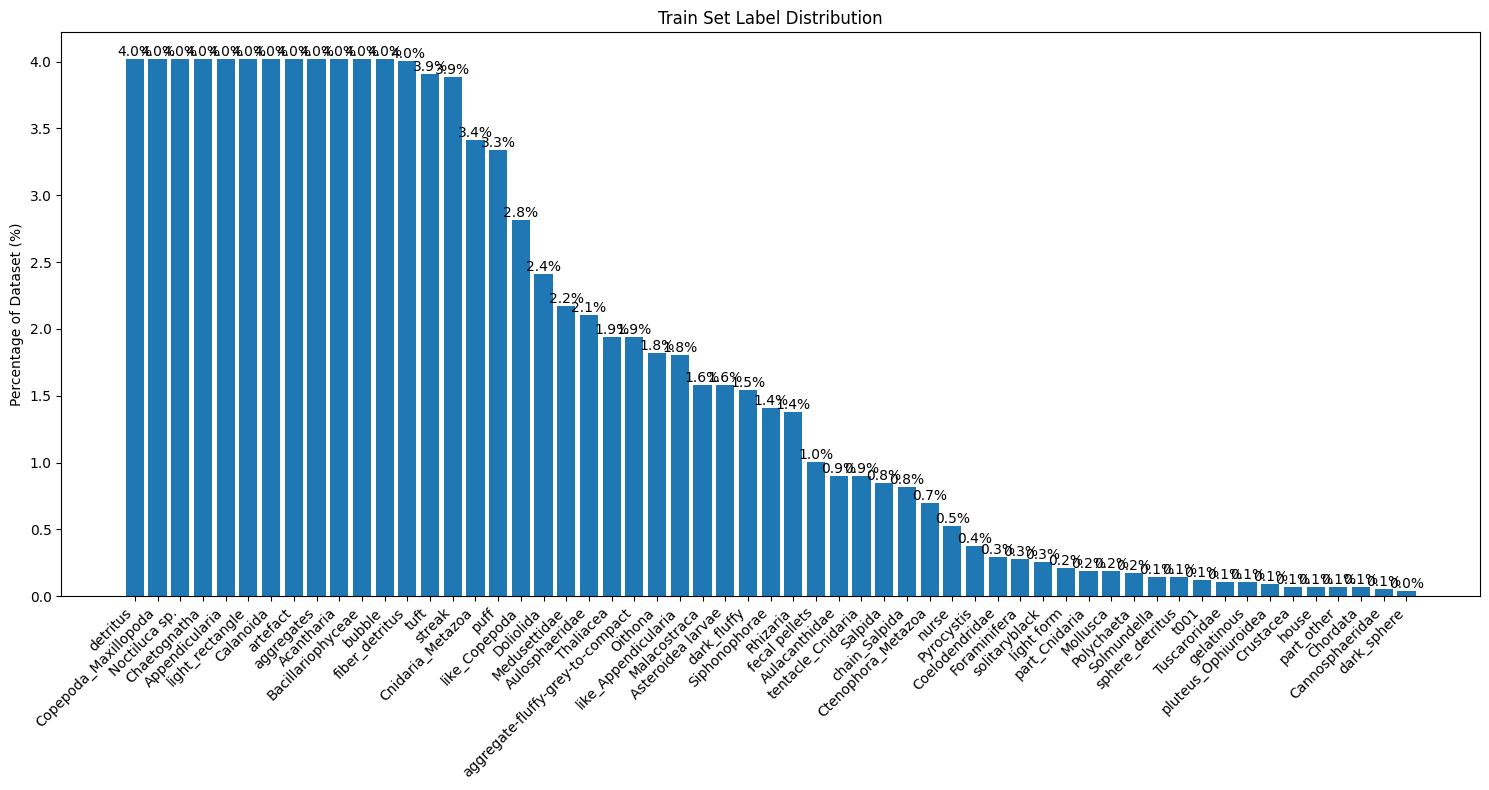


Validation Set Distribution:

Dataset Statistics:
Total samples: 2489

Class distribution:
Appendicularia: 100 samples (4.0%)
light_rectangle: 100 samples (4.0%)
fiber_detritus: 100 samples (4.0%)
detritus: 100 samples (4.0%)
Chaetognatha: 100 samples (4.0%)
Noctiluca sp.: 100 samples (4.0%)
artefact: 100 samples (4.0%)
bubble: 100 samples (4.0%)
Bacillariophyceae: 100 samples (4.0%)
Copepoda_Maxillopoda: 100 samples (4.0%)
Calanoida: 100 samples (4.0%)
aggregates: 100 samples (4.0%)
Acantharia: 100 samples (4.0%)
streak: 97 samples (3.9%)
tuft: 97 samples (3.9%)
Cnidaria_Metazoa: 85 samples (3.4%)
puff: 82 samples (3.3%)
like_Copepoda: 70 samples (2.8%)
Doliolida: 60 samples (2.4%)
Medusettidae: 54 samples (2.2%)
Aulosphaeridae: 52 samples (2.1%)
aggregate-fluffy-grey-to-compact: 48 samples (1.9%)
Thaliacea: 48 samples (1.9%)
Oithona: 45 samples (1.8%)
like_Appendicularia: 45 samples (1.8%)
Asteroidea larvae: 40 samples (1.6%)
Malacostraca: 40 samples (1.6%)
dark_fluffy: 37 samples (

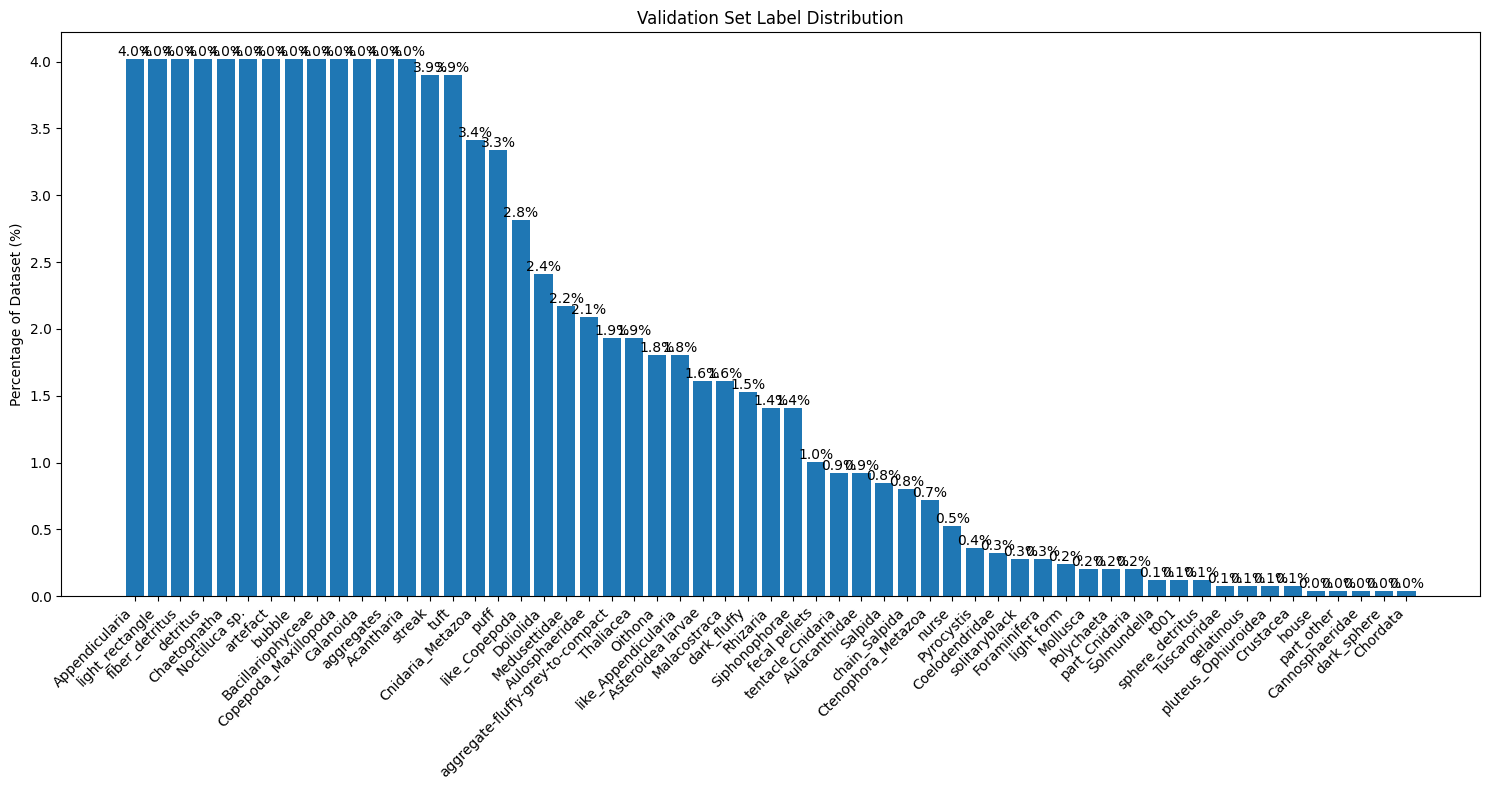


Test Set Distribution:

Dataset Statistics:
Total samples: 2489

Class distribution:
light_rectangle: 100 samples (4.0%)
Bacillariophyceae: 100 samples (4.0%)
Noctiluca sp.: 100 samples (4.0%)
Appendicularia: 100 samples (4.0%)
Copepoda_Maxillopoda: 100 samples (4.0%)
Acantharia: 100 samples (4.0%)
fiber_detritus: 100 samples (4.0%)
bubble: 100 samples (4.0%)
artefact: 100 samples (4.0%)
detritus: 100 samples (4.0%)
Chaetognatha: 100 samples (4.0%)
Calanoida: 100 samples (4.0%)
aggregates: 100 samples (4.0%)
tuft: 97 samples (3.9%)
streak: 97 samples (3.9%)
Cnidaria_Metazoa: 85 samples (3.4%)
puff: 82 samples (3.3%)
like_Copepoda: 70 samples (2.8%)
Doliolida: 60 samples (2.4%)
Medusettidae: 54 samples (2.2%)
Aulosphaeridae: 53 samples (2.1%)
aggregate-fluffy-grey-to-compact: 49 samples (2.0%)
Thaliacea: 49 samples (2.0%)
Oithona: 46 samples (1.8%)
like_Appendicularia: 45 samples (1.8%)
Malacostraca: 39 samples (1.6%)
Asteroidea larvae: 39 samples (1.6%)
dark_fluffy: 37 samples (1.5%)


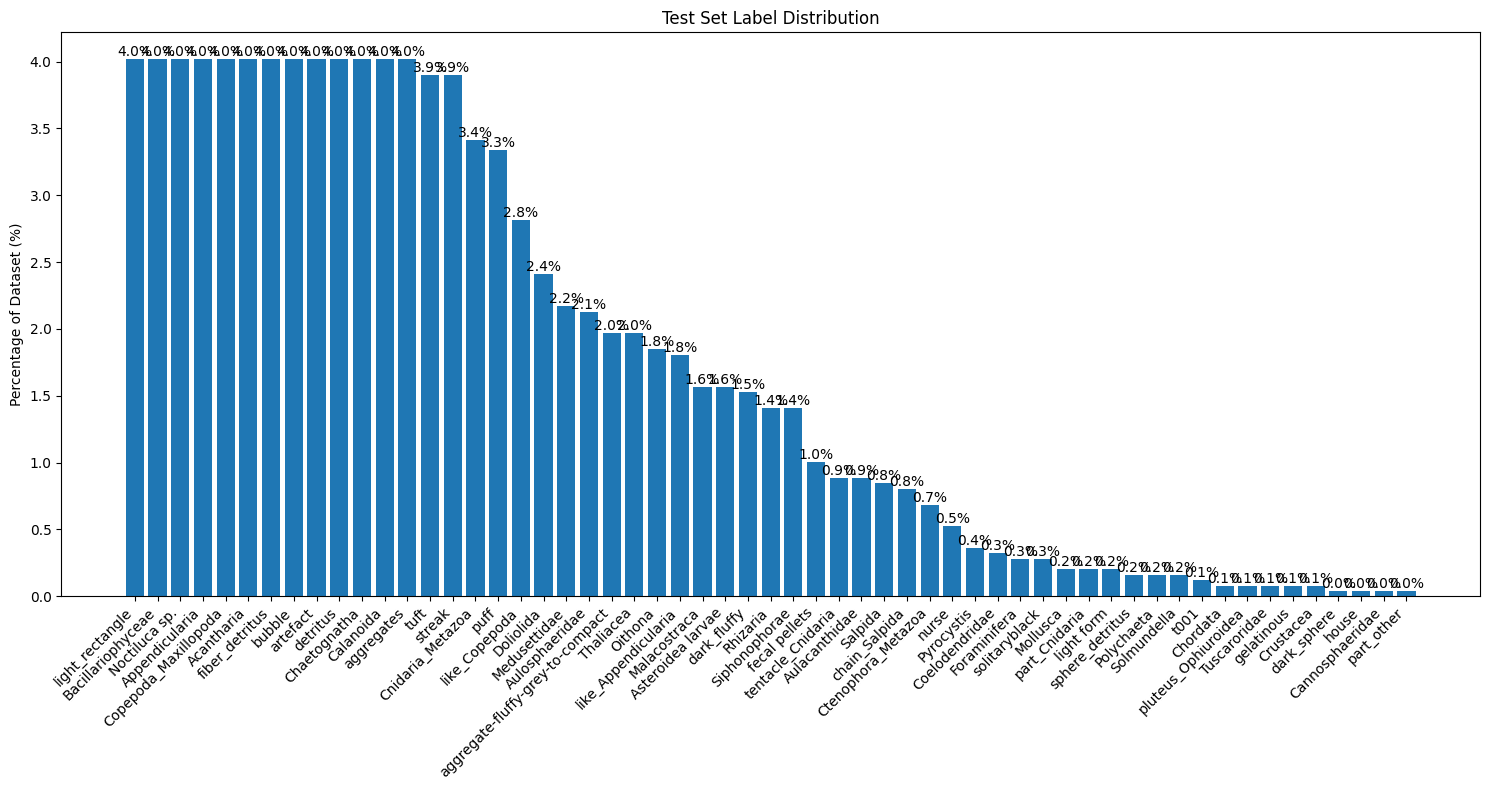

In [48]:
#root_dir = '/home/veit/Documents/M181_raw_trainset'
#root_dir = '/home/veit/Downloads/export__TSV_17108_20250616_1412'

# First define your dataset paths and scale bar flags
dataset_paths = {
    '/home/veit/Downloads/export__TSV_17420_20250627_0905': False,
    '/home/veit/Downloads/export__TSV_17108_20250616_1412': True,
}

# Specify the output directory for the merged dataset
output_dir = "/home/veit/Documents/M181_reinforced_deconv_trainset"

# Merge the datasets
merged_ds = merge_datasets(dataset_paths, output_dir=output_dir)

# First load the full dataset
#full_ds = load_dataset("imagefolder", data_dir=root_dir)

# Classes to merge
merge_classes = {
    'Appendicularia': ['Appendicularia', 'body_Appendicularia'],
    #'detritus': ['detritus_small', 'detritus_large', 'marine_snow']
}

# Classes to exclude
exclude_classes = ['othertocheck', 'sphere_othertocheck', 'multiple_other']  

# Process the full dataset before splitting
processed_full_ds = preprocess_dataset(
    merged_ds,
    min_samples=5,      # Minimum 5 samples per class
    max_samples=500,    # Maximum 500 samples per class
    merge_classes=merge_classes,
    exclude_classes=exclude_classes
)

# Then split into train/validation/test
train_val_test = processed_full_ds.train_test_split(
    test_size=0.2,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

train_val = train_val_test['train'].train_test_split(
    test_size=0.25,
    seed=42,
    shuffle=True,
    stratify_by_column="label"
)

ds = DatasetDict({
    'train': train_val['train'],
    'validation': train_val['test'],
    'test': train_val_test['test']
})

# Verify the distribution
print("\nFinal dataset distribution:")
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} Set Distribution:")
    analyze_label_distribution(ds[split], f"{split.capitalize()} Set Label Distribution")

labels = ds['train'].features['label'].names

# Apply the custom image processor to the dataset
prepared_ds = ds.with_transform(process_batch)

In [49]:
# Dataset structure and sample counts

ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7466
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2489
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2489
    })
})

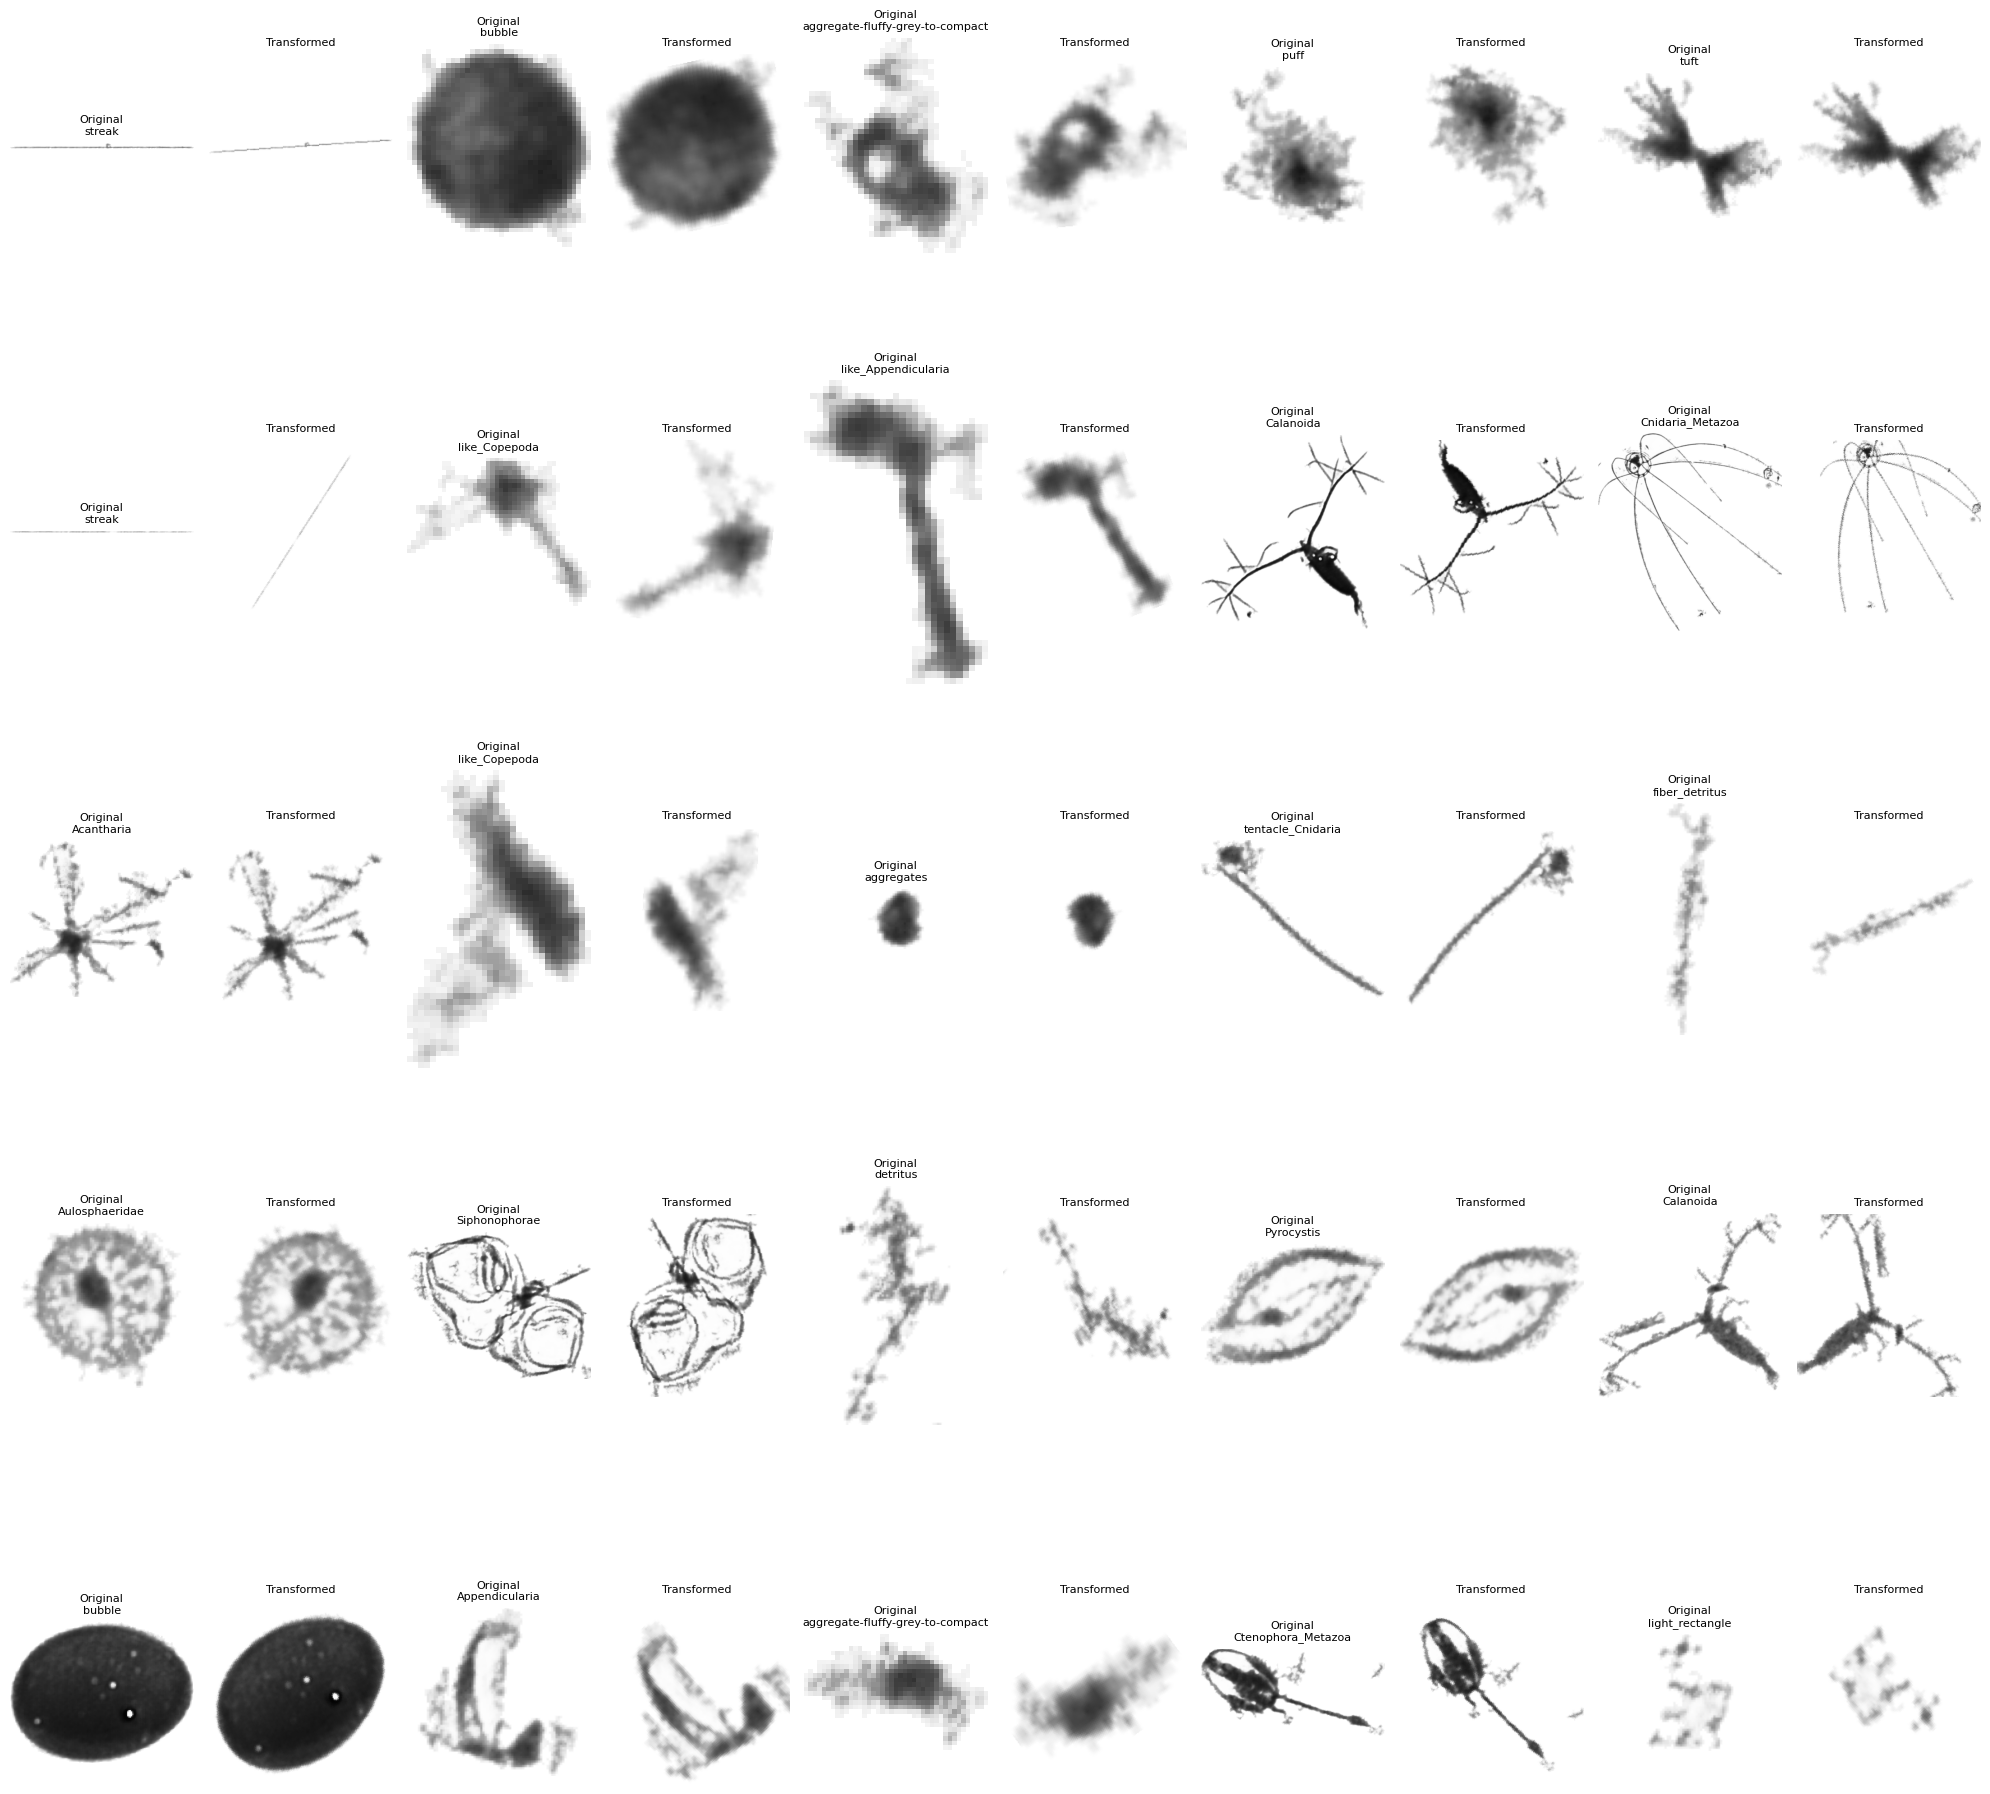

In [50]:
# Show the effect of the transformations that are applied to each image. Images will be shown in pairs: original and transformed.
# This is how the ViT will receive the images... sort of at least.

visualize_transformations(prepared_ds['train'], ds['train'])

## Setup of the ViT 

In [51]:
#model_name_or_path = 'google/vit-base-patch16-224-in21k'
model_name_or_path = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/best_model'

root_dir = "/home/veit/PIScO_dev/ViT_custom_size_sensitive_v2/"  # Path where all config files and checkpoints will be saved

In [ ]:
#processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

# metric = evaluate.load("accuracy")

# def compute_metrics(p):
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)



training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  eval_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=25,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,

)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    
    #tokenizer=processor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at /home/veit/PIScO_dev/ViT_custom_size_sensitive/best_model and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([48]) in the checkpoint and torch.Size([57]) in the model instantiated
- classifier.weight: found shape torch.Size([48, 768]) in the checkpoint and torch.Size([57, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Print GPU information
print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")

# Select specific GPU
torch.cuda.set_device(0)  # Use GPU 0
print(f"Using GPU: {torch.cuda.current_device()}")

Available GPUs: 1
GPU 0: Radeon RX 7900 XTX
Memory: 25.75 GB
Using GPU: 0


### Start of training

In [54]:
save_dir = os.path.join(root_dir, 'best_model')  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/veit/miniconda3/envs/pisco/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Flash Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:452.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


***** train metrics *****
  epoch                    =          25.0
  total_flos               = 13477178100GF
  train_loss               =        0.2066
  train_runtime            =    0:22:16.50
  train_samples_per_second =       139.656
  train_steps_per_second   =         8.735


## Analysis of the training. 
### Metrics and visualization 

In [55]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

test_ds = ds['test'].with_transform(process_batch)
test_outputs = trainer.predict(test_ds)

***** test metrics *****
  epoch                   =       25.0
  eval_accuracy           =     0.8694
  eval_loss               =     0.4332
  eval_runtime            = 0:00:09.20
  eval_samples_per_second =    270.295
  eval_steps_per_second   =     33.882


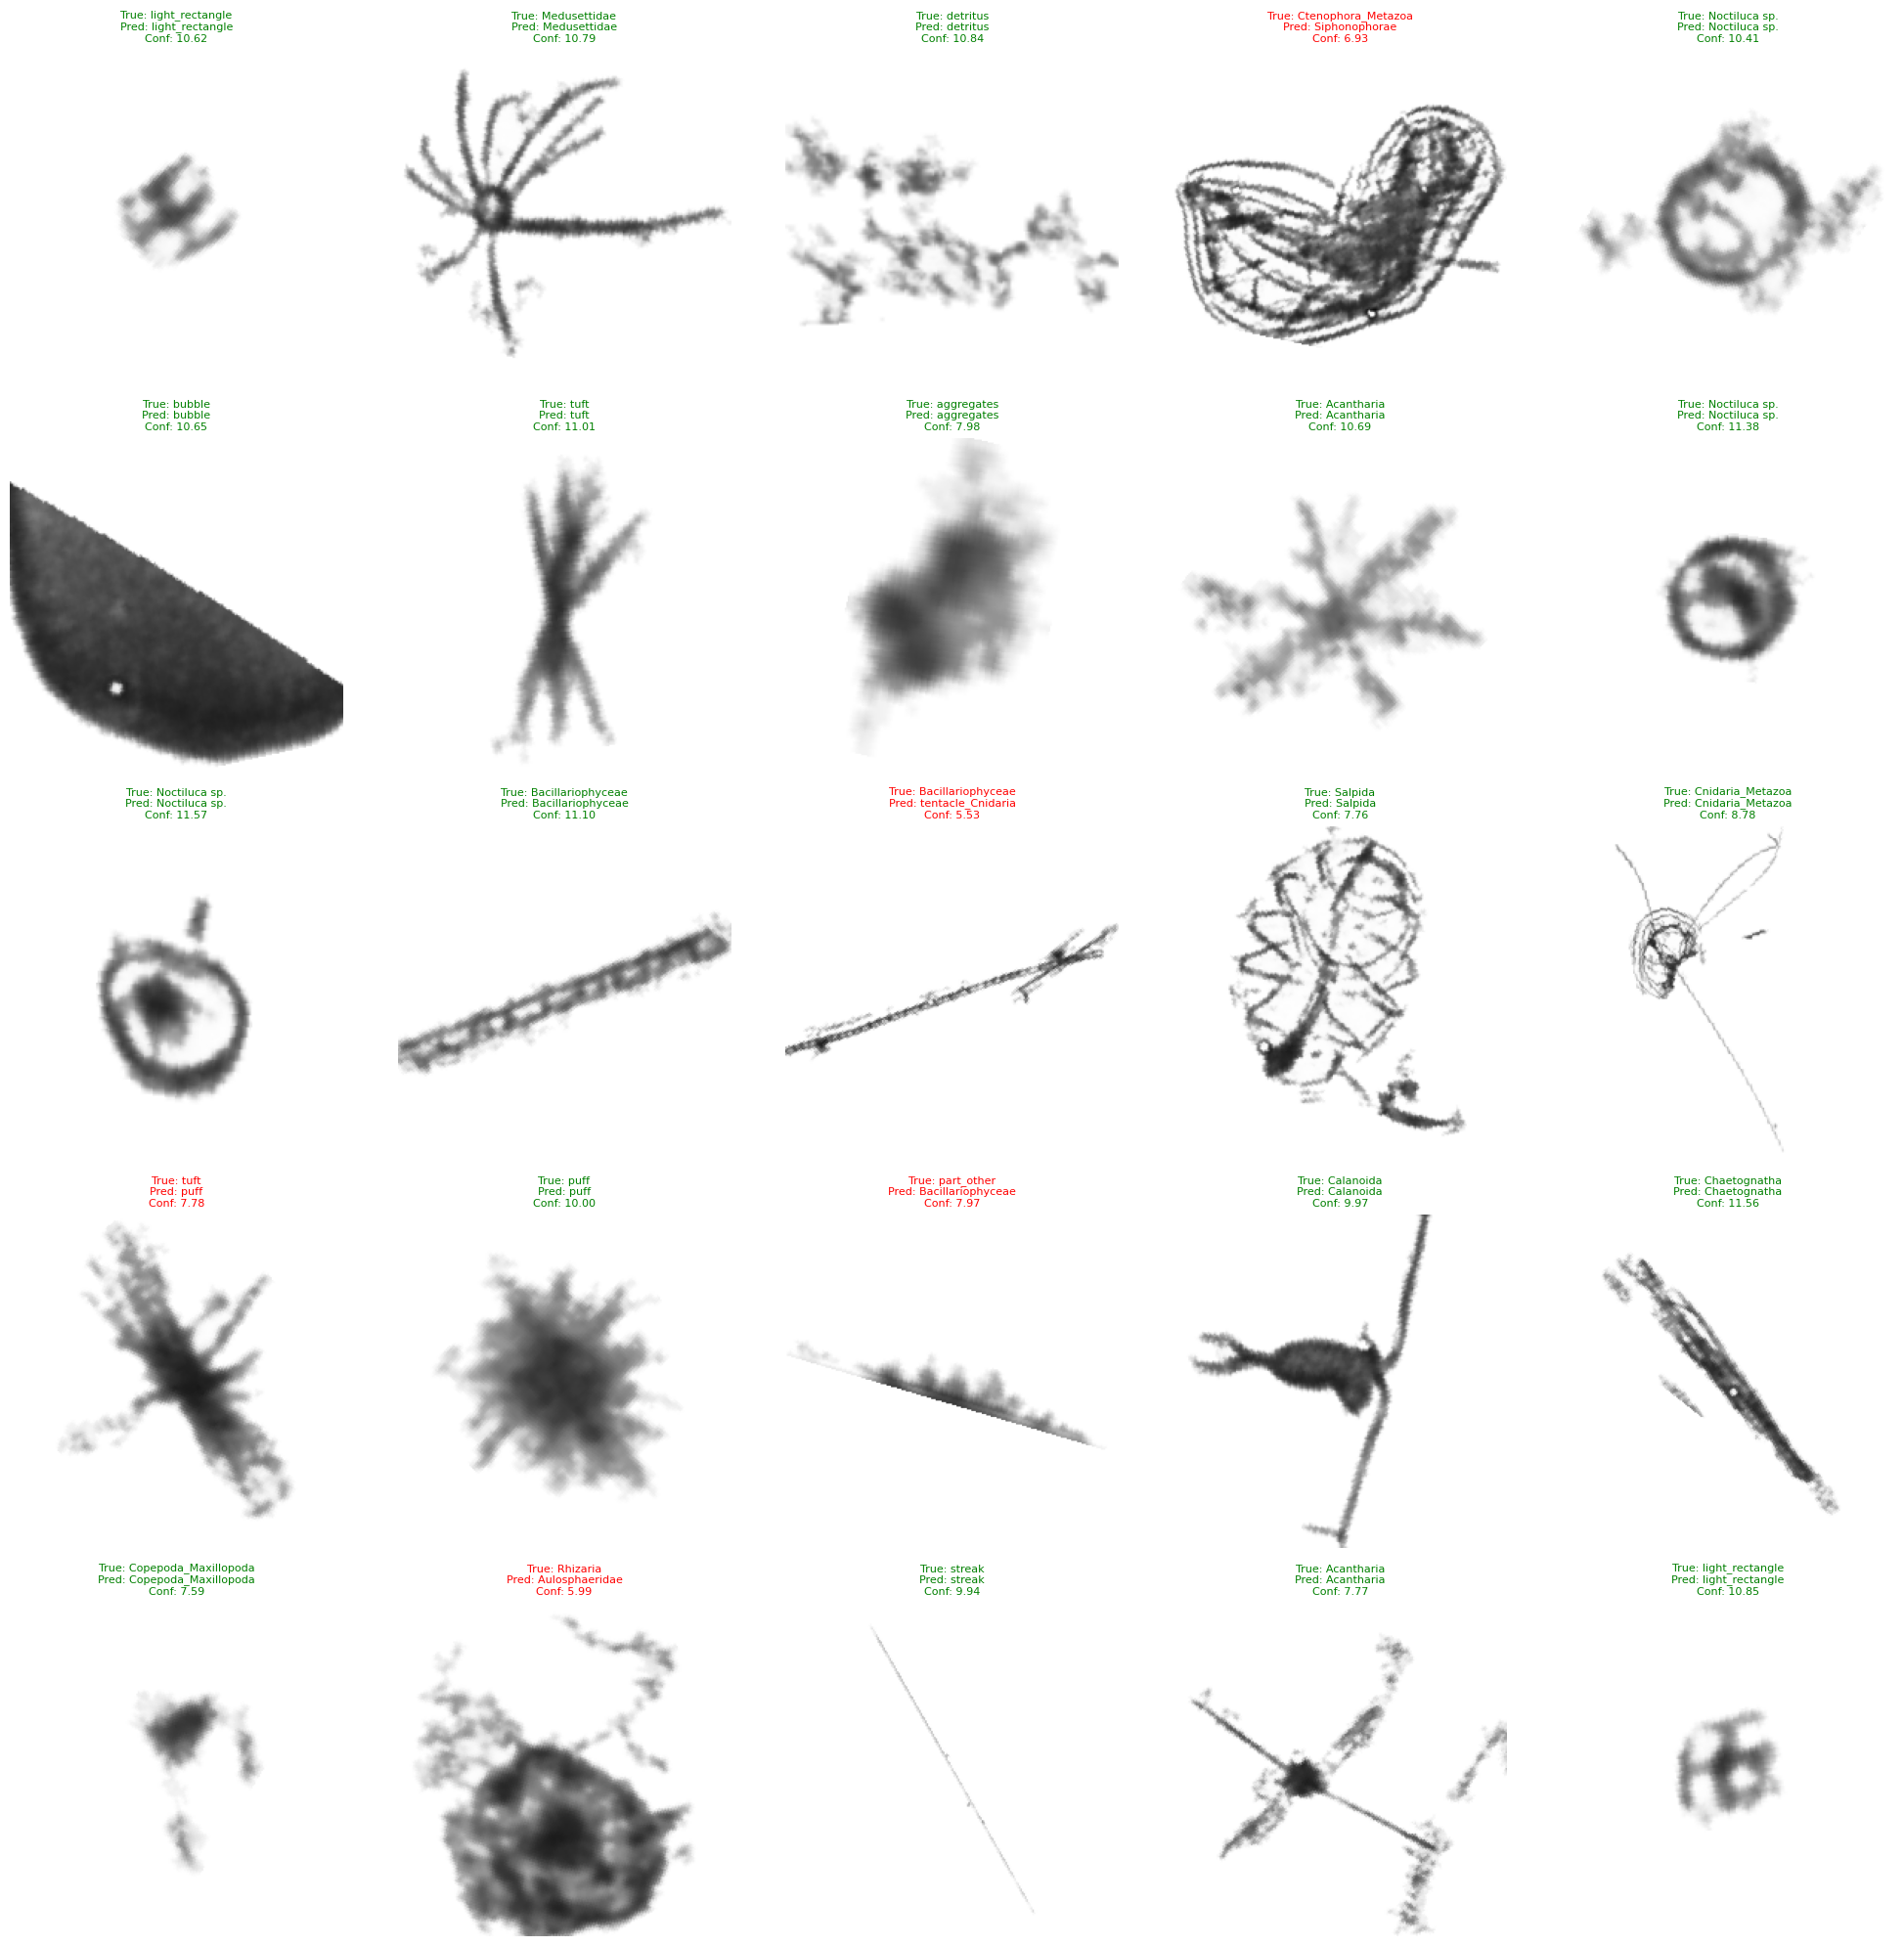


Overall Accuracy: 85.86%


In [56]:
def visualize_predictions(test_outputs, dataset, num_samples=25, rows=5, cols=5):
    """
    Visualize random samples with their true and predicted labels.
    
    Args:
        model: Trained ViT model
        dataset: Dataset with transformed images
        num_samples: Number of samples to visualize
        rows: Number of rows in the grid
        cols: Number of columns in the grid
    """
    # Get predictions for the whole dataset
    predictions = test_outputs.predictions.argmax(1)
    
    # Get random indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    # Get label names
    label_names = dataset.features['label'].names
    
    for idx, sample_idx in enumerate(random_indices):
        # Get original image and prediction
        sample = dataset[sample_idx]
        true_label = label_names[sample['label']]
        pred_label = label_names[predictions[sample_idx]]
        
        # Get confidence score
        confidence = test_outputs.predictions[sample_idx].max()
        
        # Create color for title based on correct/incorrect prediction
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with true and predicted labels
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}'
        plt.title(title, color=title_color, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Print overall accuracy
    accuracy = (predictions == test_outputs.label_ids).mean()
    print(f"\nOverall Accuracy: {accuracy:.2%}")

# Visualize predictions on the test set
visualize_predictions(test_outputs, test_ds, num_samples=25, rows=5, cols=5)

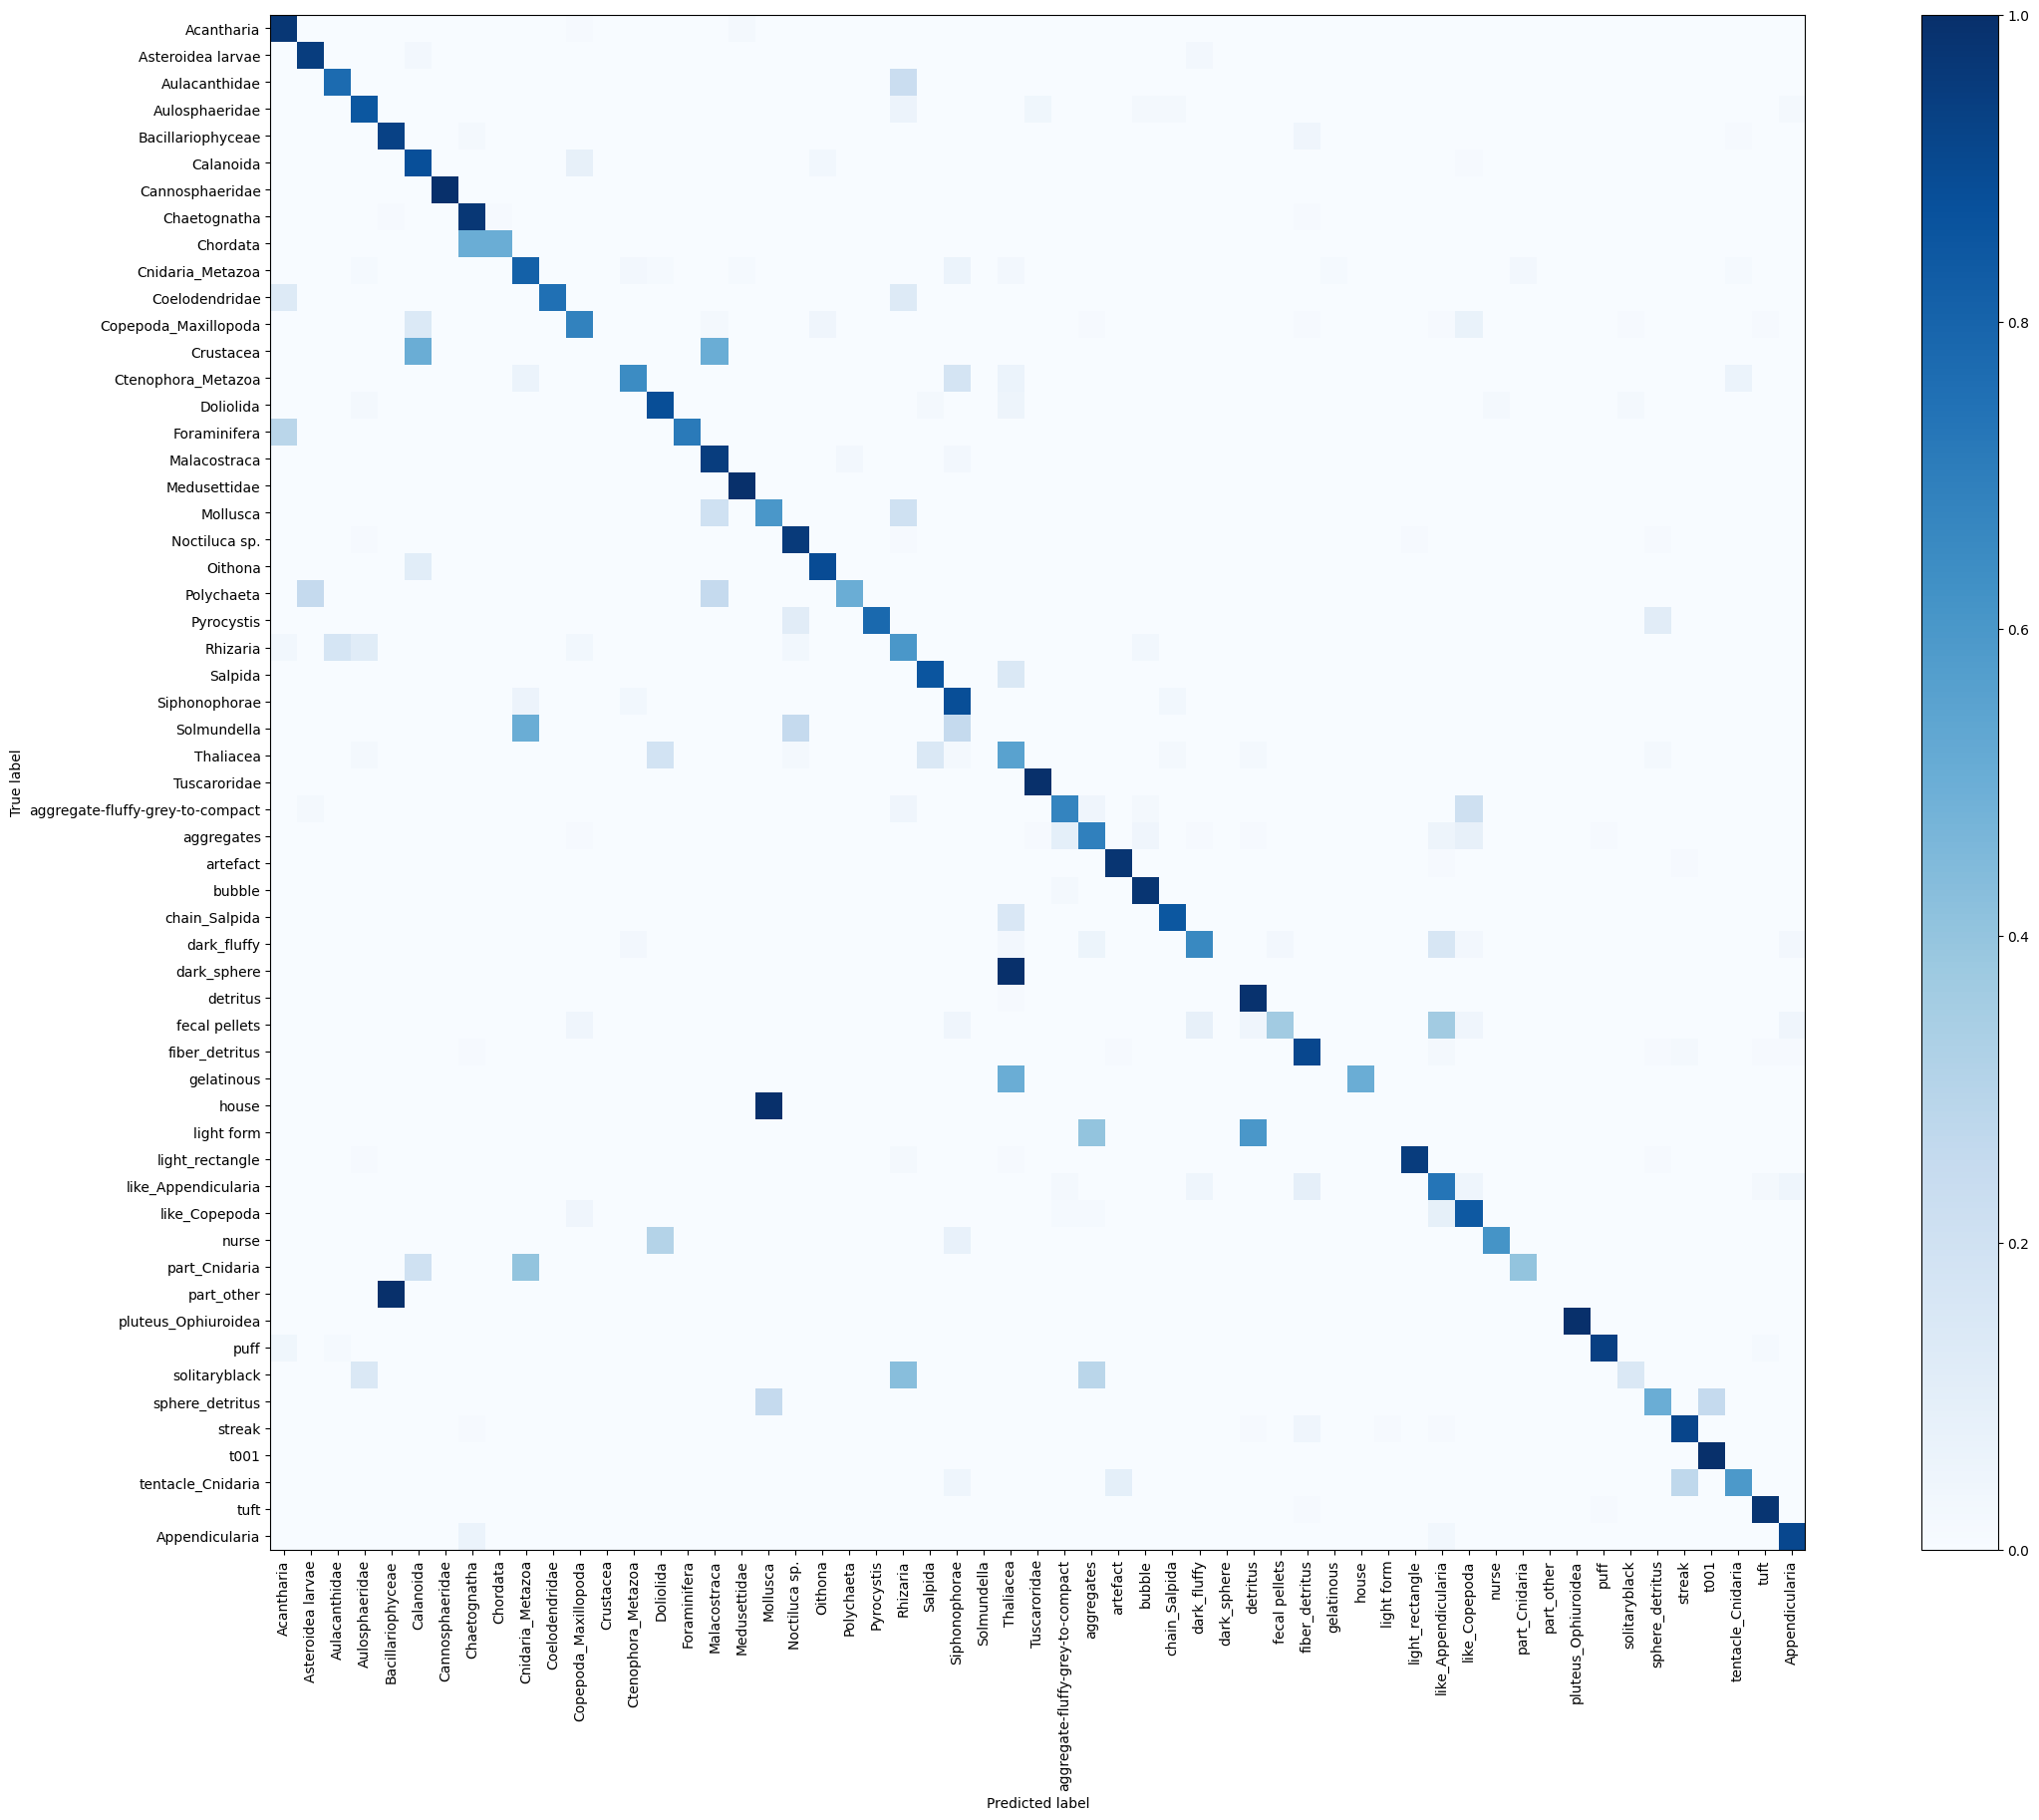


Class-wise Analysis:
--------------------------------------------------------------------------------

Class: Acantharia
Recall: 0.97
Most confused with:
  - Medusettidae: 2.00%
  - Copepoda_Maxillopoda: 1.00%

Class: Asteroidea larvae
Recall: 0.95
Most confused with:
  - dark_fluffy: 2.56%
  - Calanoida: 2.56%

Class: Aulacanthidae
Recall: 0.77
Most confused with:
  - Rhizaria: 22.73%

Class: Aulosphaeridae
Recall: 0.85
Most confused with:
  - Rhizaria: 5.66%
  - Tuscaroridae: 3.77%
  - bubble: 1.89%

Class: Bacillariophyceae
Recall: 0.93
Most confused with:
  - fiber_detritus: 4.00%
  - Chaetognatha: 2.00%
  - tentacle_Cnidaria: 1.00%

Class: Calanoida
Recall: 0.88
Most confused with:
  - Copepoda_Maxillopoda: 8.00%
  - Oithona: 3.00%
  - like_Copepoda: 1.00%

Class: Cannosphaeridae
Recall: 1.00
Most confused with:

Class: Chaetognatha
Recall: 0.97
Most confused with:
  - fiber_detritus: 1.00%
  - Chordata: 1.00%
  - Bacillariophyceae: 1.00%

Class: Chordata
Recall: 0.50
Most confus

In [57]:
# Calculate and visualize confusion matrix

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a larger figure
fig, ax = plt.subplots(figsize=(30, 20))  # Create a figure and a set of subplots with specified size

# Define a colormap
cmap = plt.get_cmap('Blues')

# Create the confusion matrix display with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)

# Plot the confusion matrix
disp.plot(cmap=cmap, xticks_rotation='vertical', values_format='.2f', ax=ax)
# Remove the annotations
for text in disp.text_.ravel():
    text.set_visible(False)

# Show the plot
plt.show()

# # Calculate recall for each class
# recall = recall_score(y_true, y_pred, average=None)

# # Print the recall for each class
# for label, score in zip(labels, recall):
#   print(f"Recall for {label}: {score:.2f}")
# Calculate recall for each class and find most confused categories
print("\nClass-wise Analysis:")
print("-" * 80)
for i, label in enumerate(labels):
    # Calculate recall
    recall = cm[i, i] / cm[i].sum()
    
    # Find the most confused categories (excluding self-predictions)
    confusion_scores = cm_normalized[i]
    confusion_scores[i] = 0  # Exclude self-predictions
    most_confused_idx = np.argsort(confusion_scores)[-3:][::-1]  # Get top 3 confused categories
    
    print(f"\nClass: {label}")
    print(f"Recall: {recall:.2f}")
    print("Most confused with:")
    for idx in most_confused_idx:
        if confusion_scores[idx] > 0:  # Only show if there's actual confusion
            print(f"  - {labels[idx]}: {confusion_scores[idx]:.2%}")
print("-" * 80)

# Inference on test profile

In [58]:
def load_unclassified_images(data_dir):
    """
    Load unclassified images from a directory, filtering for valid image files.
    
    Args:
        data_dir (str): Path to directory containing images
        
    Returns:
        Dataset: HuggingFace dataset containing images
    """
    # Define valid image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')
    
    # List all files in the directory and filter for valid image files
    image_files = [
        os.path.join(data_dir, f) 
        for f in os.listdir(data_dir) 
        if os.path.isfile(os.path.join(data_dir, f))
        and f.lower().endswith(valid_extensions)
    ]

    # Prepare data for the dataset
    data = {
        'image': image_files,
        'label': image_files 
    }
    
    features = Features({
        'image': ImageFeature(),
        'label': Value('string')
    })
    
    # Create the dataset
    dataset = Dataset.from_dict(data, features=features)
    return dataset


def get_predictions_on_dataset_in_batches(dataset, save_dir, batch_size=64):
    print("Initializing model for predictions")
    vit = ViTForImageClassification.from_pretrained(save_dir)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()  # Ensure model is in eval mode
    
    # Optimize DataLoader
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,  # Parallel data loading
        pin_memory=True,  # Faster CPU to GPU transfer
        prefetch_factor=2  # Prefetch batches
    )
    
    predictions = []
    filenames = []
    probabilities = []
    
    with torch.amp.autocast('cuda'):  # Enable automatic mixed precision
        for batch in tqdm(dataloader, desc="Processing dataset"):
            # Batch processing in one go
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Process predictions efficiently
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            top_probs, top_indices = torch.topk(probs, 5, dim=-1)
            
            # Batch process labels
            batch_labels = [[vit.config.id2label[idx.item()] for idx in indices] 
                          for indices in top_indices]
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.cpu().numpy())
    
    print(f"Predictions completed for {len(filenames)} images")
    return filenames, predictions, probabilities

def get_predictions_with_entropy_ood(dataset, save_dir, entropy_threshold=1.0, temperature=1.5, batch_size=64):
    print("Initializing model for predictions")
    vit = ViTForImageClassification.from_pretrained(save_dir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit.to(device)
    vit.eval()
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )
    
    predictions = []
    filenames = []
    probabilities = []
    entropy_scores = []
    ood_flags = []
    
    with torch.amp.autocast('cuda'):
        for batch in tqdm(dataloader, desc="Processing dataset"):
            inputs = batch['pixel_values'].to(device, non_blocking=True)
            
            with torch.no_grad():
                outputs = vit(pixel_values=inputs)
            
            # Apply temperature scaling
            scaled_logits = outputs.logits / temperature
            probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
            
            # Calculate entropy
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            
            top_probs, top_indices = torch.topk(probs, 5, dim=-1)
            
            batch_labels = [[vit.config.id2label[idx.item()] for idx in indices] 
                          for indices in top_indices]
            
            # Flag samples as OOD if entropy is above threshold
            batch_ood = (entropy > entropy_threshold).cpu().numpy()
            
            predictions.extend(batch_labels)
            filenames.extend(batch['label'])
            probabilities.extend(top_probs.cpu().numpy())
            entropy_scores.extend(entropy.cpu().numpy())
            ood_flags.extend(batch_ood)
    
    return filenames, predictions, probabilities, entropy_scores, ood_flags

def custom_image_processor(image, target_size=(224, 224), padding_color=255, size_bar=False):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    if size_bar:
        # Step 0: Remove scale bar by cropping the bottom 50 pixels
        width, height = image.size
        image = image.crop((0, 0, width, height - 50))  # Crop out the scale bar area
    
    # Step 1: Resize the image
    resized_image = resize_to_larger_edge(image,224)

    if resized_image is None:  # Skip processing if resizing failed
        #print(f"Skipping image due to resize failure: {image.size}")
        return None  # This allows to filter out bad images later

    #Step 2: Calculate padding
    new_width, new_height = resized_image.size
    padding_left = (target_size[0] - new_width) // 2
    padding_right = target_size[0] - new_width - padding_left
    padding_top = (target_size[1] - new_height) // 2
    padding_bottom = target_size[1] - new_height - padding_top

    # Step 3: Apply padding
    padding = (padding_left, padding_top, padding_right, padding_bottom)
    pad_transform = transforms.Pad(padding, fill=padding_color)
    padded_image = pad_transform(resized_image)

    # Step 4: Apply other transformations
    transform_chain = transforms.Compose([
        transforms.RandomRotation(degrees=180,fill=255),
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    
    # Apply the transformations
    return transform_chain(padded_image)

In [64]:
img_dir = "/home/veit/PIScO_dev/Segmentation_results/M181/M181-175-1_CTD-050_00°00S-019°00W_20220509-0543/Deconv_crops"  # Replace with your actual path to unclassified images
ds_pisco = load_unclassified_images(img_dir)

destination_path = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/predictions'
os.makedirs(destination_path, exist_ok=True)

# Apply the transform to the dataset
ds_pisco_trans = ds_pisco.with_transform(process_batch)

# Define model name and path to the saved model
model_dir = '/home/veit/PIScO_dev/ViT_custom_size_sensitive/best_model'

# Get predictions on the dataset in batches
#filenames, predictions, probabilities = get_predictions_on_dataset_in_batches(ds_pisco_trans, model_dir, batch_size=64)
# Using entropy-based OOD detection
filenames, predictions, probabilities, entropy_scores, ood_flags = get_predictions_with_entropy_ood(
    ds_pisco_trans, 
    model_dir, 
    entropy_threshold=1,  # Tune this threshold
    temperature=1.5,        # Tune this parameter
    batch_size=64
)

# Create a DataFrame and store it on disk
# df = pd.DataFrame({
#     'filename': filenames,
#     'top1': [pred[0] for pred in predictions],
#     'top2': [pred[1] for pred in predictions],
#     'top3': [pred[2] for pred in predictions],
#     'top4': [pred[3] for pred in predictions],
#     'top5': [pred[4] for pred in predictions],
#     'prob1': [prob[0] for prob in probabilities],
#     'prob2': [prob[1] for prob in probabilities],
#     'prob3': [prob[2] for prob in probabilities],
#     'prob4': [prob[3] for prob in probabilities],
#     'prob5': [prob[4] for prob in probabilities]
# })    
# Create DataFrame with OOD detection results
df = pd.DataFrame({
    'filename': filenames,
    'is_ood': ood_flags,
    'entropy': entropy_scores,
    'top1': [pred[0] for pred in predictions],
    'top2': [pred[1] for pred in predictions],
    'top3': [pred[2] for pred in predictions],
    'top4': [pred[3] for pred in predictions],
    'top5': [pred[4] for pred in predictions],
    'prob1': [prob[0] for prob in probabilities],
    'prob2': [prob[1] for prob in probabilities],
    'prob3': [prob[2] for prob in probabilities],
    'prob4': [prob[3] for prob in probabilities],
    'prob5': [prob[4] for prob in probabilities]
})
result_path = os.path.join(destination_path, 'ViT_predictions.csv')
df.to_csv(result_path, index=False)
print("Predictions saved!")

# Print the first 5 predictions
print(df.head())

Initializing model for predictions


Processing dataset: 100%|██████████| 1644/1644 [01:40<00:00, 16.36it/s]


Predictions saved!
                                            filename  is_ood   entropy  \
0  /home/veit/PIScO_dev/Segmentation_results/M181...    True  2.092412   
1  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.225736   
2  /home/veit/PIScO_dev/Segmentation_results/M181...    True  1.272512   
3  /home/veit/PIScO_dev/Segmentation_results/M181...   False  0.246603   
4  /home/veit/PIScO_dev/Segmentation_results/M181...    True  1.505944   

              top1                              top2  \
0             puff                        Acantharia   
1             tuft                    fiber_detritus   
2  light_rectangle  aggregate-fluffy-grey-to-compact   
3             tuft                    fiber_detritus   
4       aggregates              Copepoda_Maxillopoda   

                               top3             top4            top5  \
0  aggregate-fluffy-grey-to-compact  light_rectangle  Aulosphaeridae   
1                              puff          Oithona   

In [65]:
print(df['filename'][1])


/home/veit/PIScO_dev/Segmentation_results/M181/M181-175-1_CTD-050_00°00S-019°00W_20220509-0543/Deconv_crops/20220509-05490348_002.181bar_28.95C_47.png



Visualizing random samples with predictions:


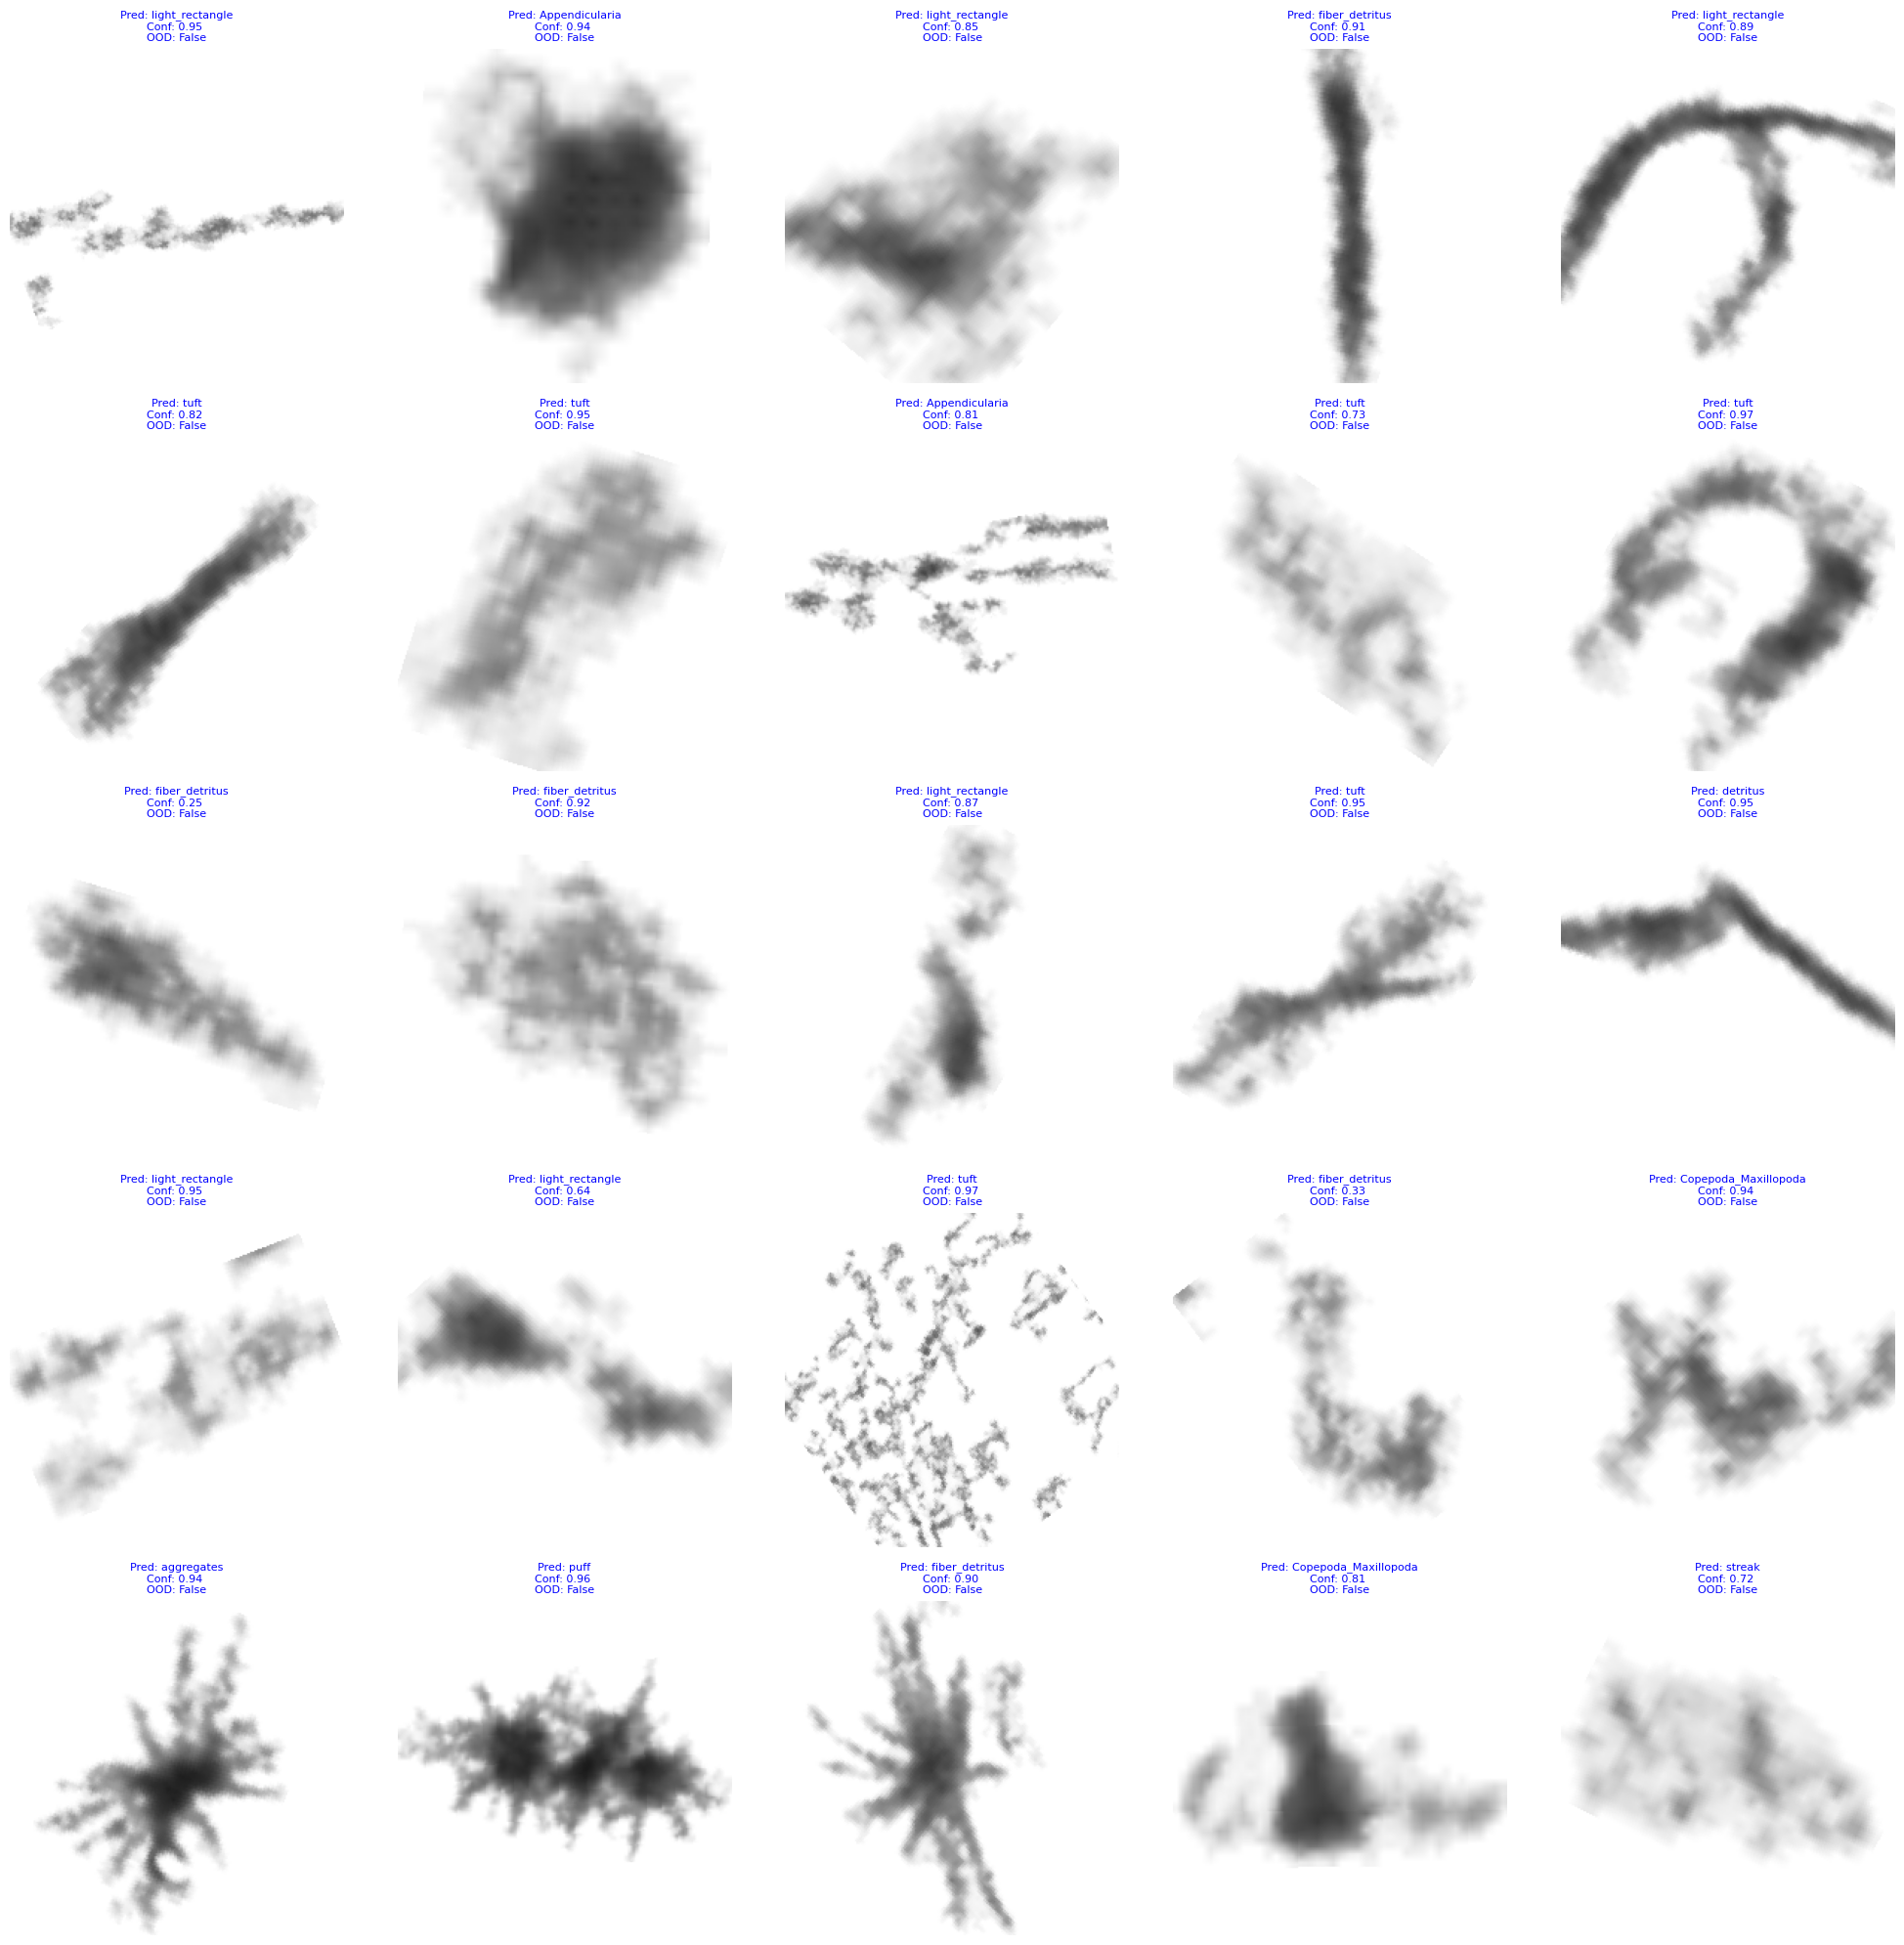

In [66]:
def visualize_inference(dataset, predictions, probabilities, num_samples=25, rows=5, cols=5):
    """
    Visualize random samples with their predicted labels and confidence scores.
    """
    # Get random indices
    total_samples = len(dataset)
    random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get image and prediction
        sample = dataset[sample_idx]
        pred_label = predictions[sample_idx][0]  # Top prediction
        confidence = probabilities[sample_idx][0]  # Top confidence
        ood_flag = sample['is_ood'] if 'is_ood' in sample else False
        
        # Create color for title based on OOD flag
        title_color = 'orange' if ood_flag else 'blue'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with predicted label and confidence
        title = f'Pred: {pred_label}\nConf: {confidence:.2f} \nOOD: {ood_flag}'
        plt.title(title, color=title_color, fontsize=8)
        plt.title(title, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Add this after the DataFrame creation:
print("\nVisualizing random samples with predictions:")
visualize_inference(ds_pisco_trans, predictions, probabilities)


Visualizing all samples:


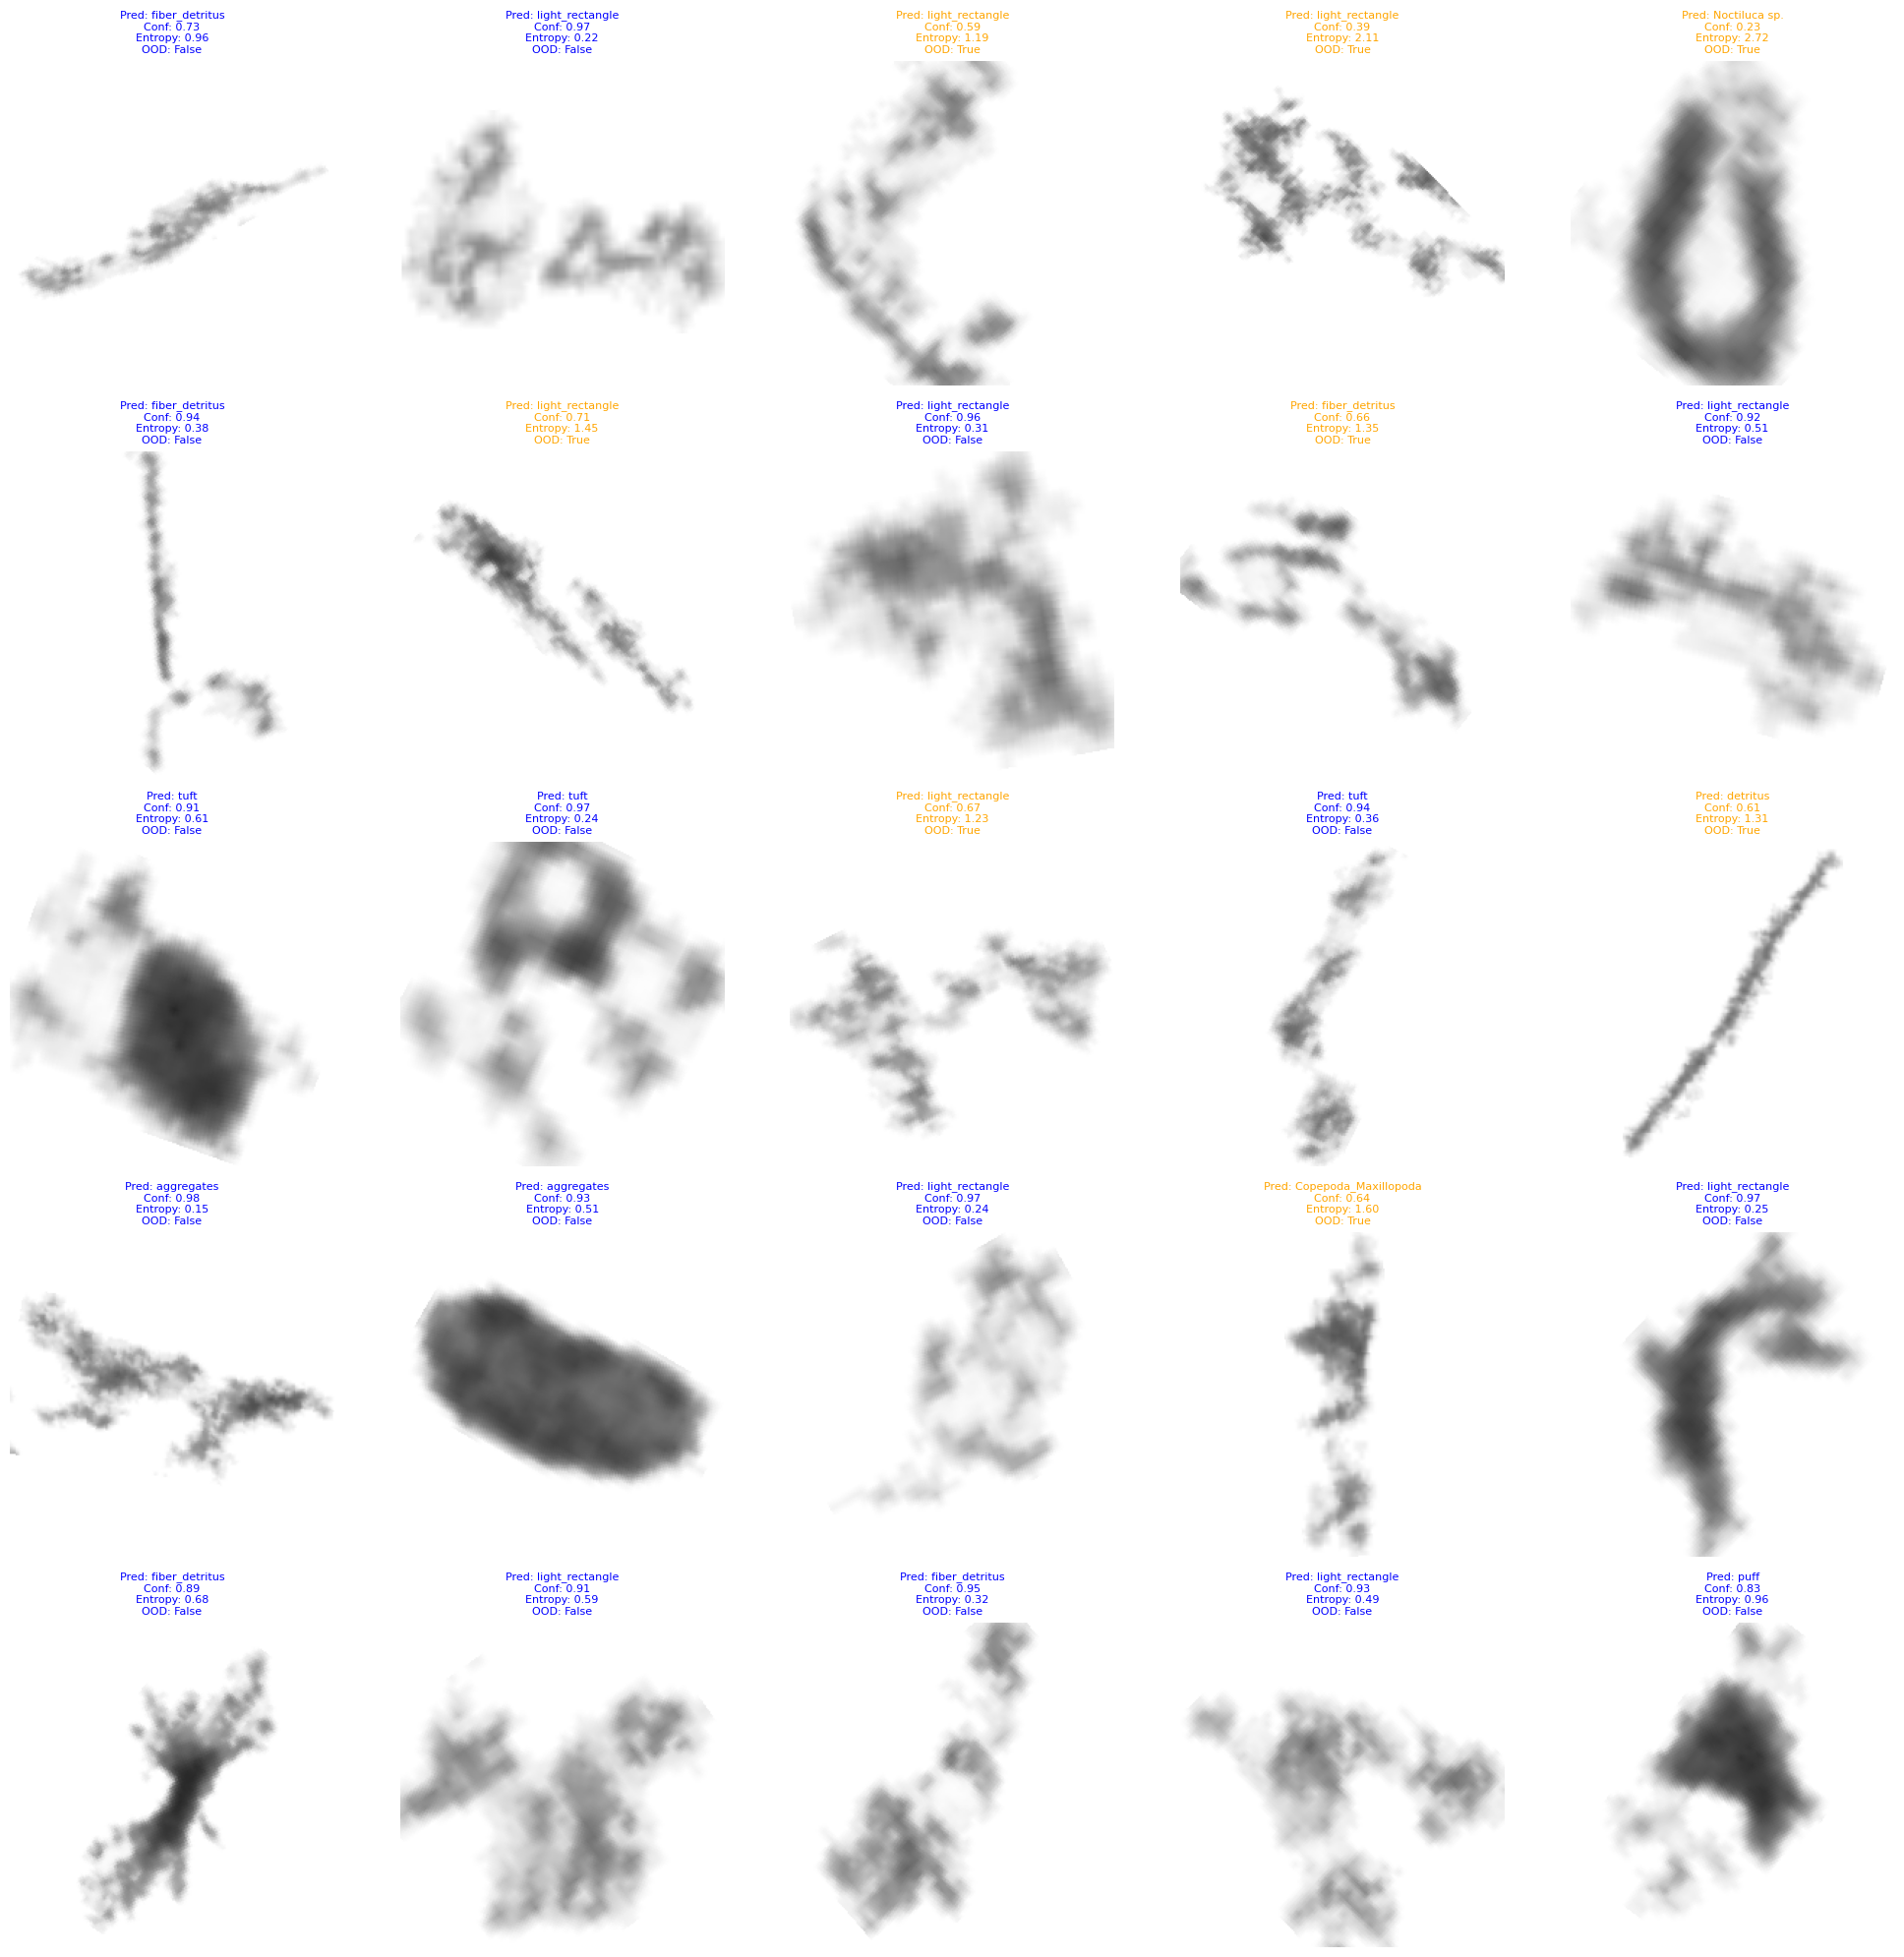


OOD Detection Summary:
Total samples: 105157
OOD samples: 40459 (38.5%)

Visualizing only OOD samples:


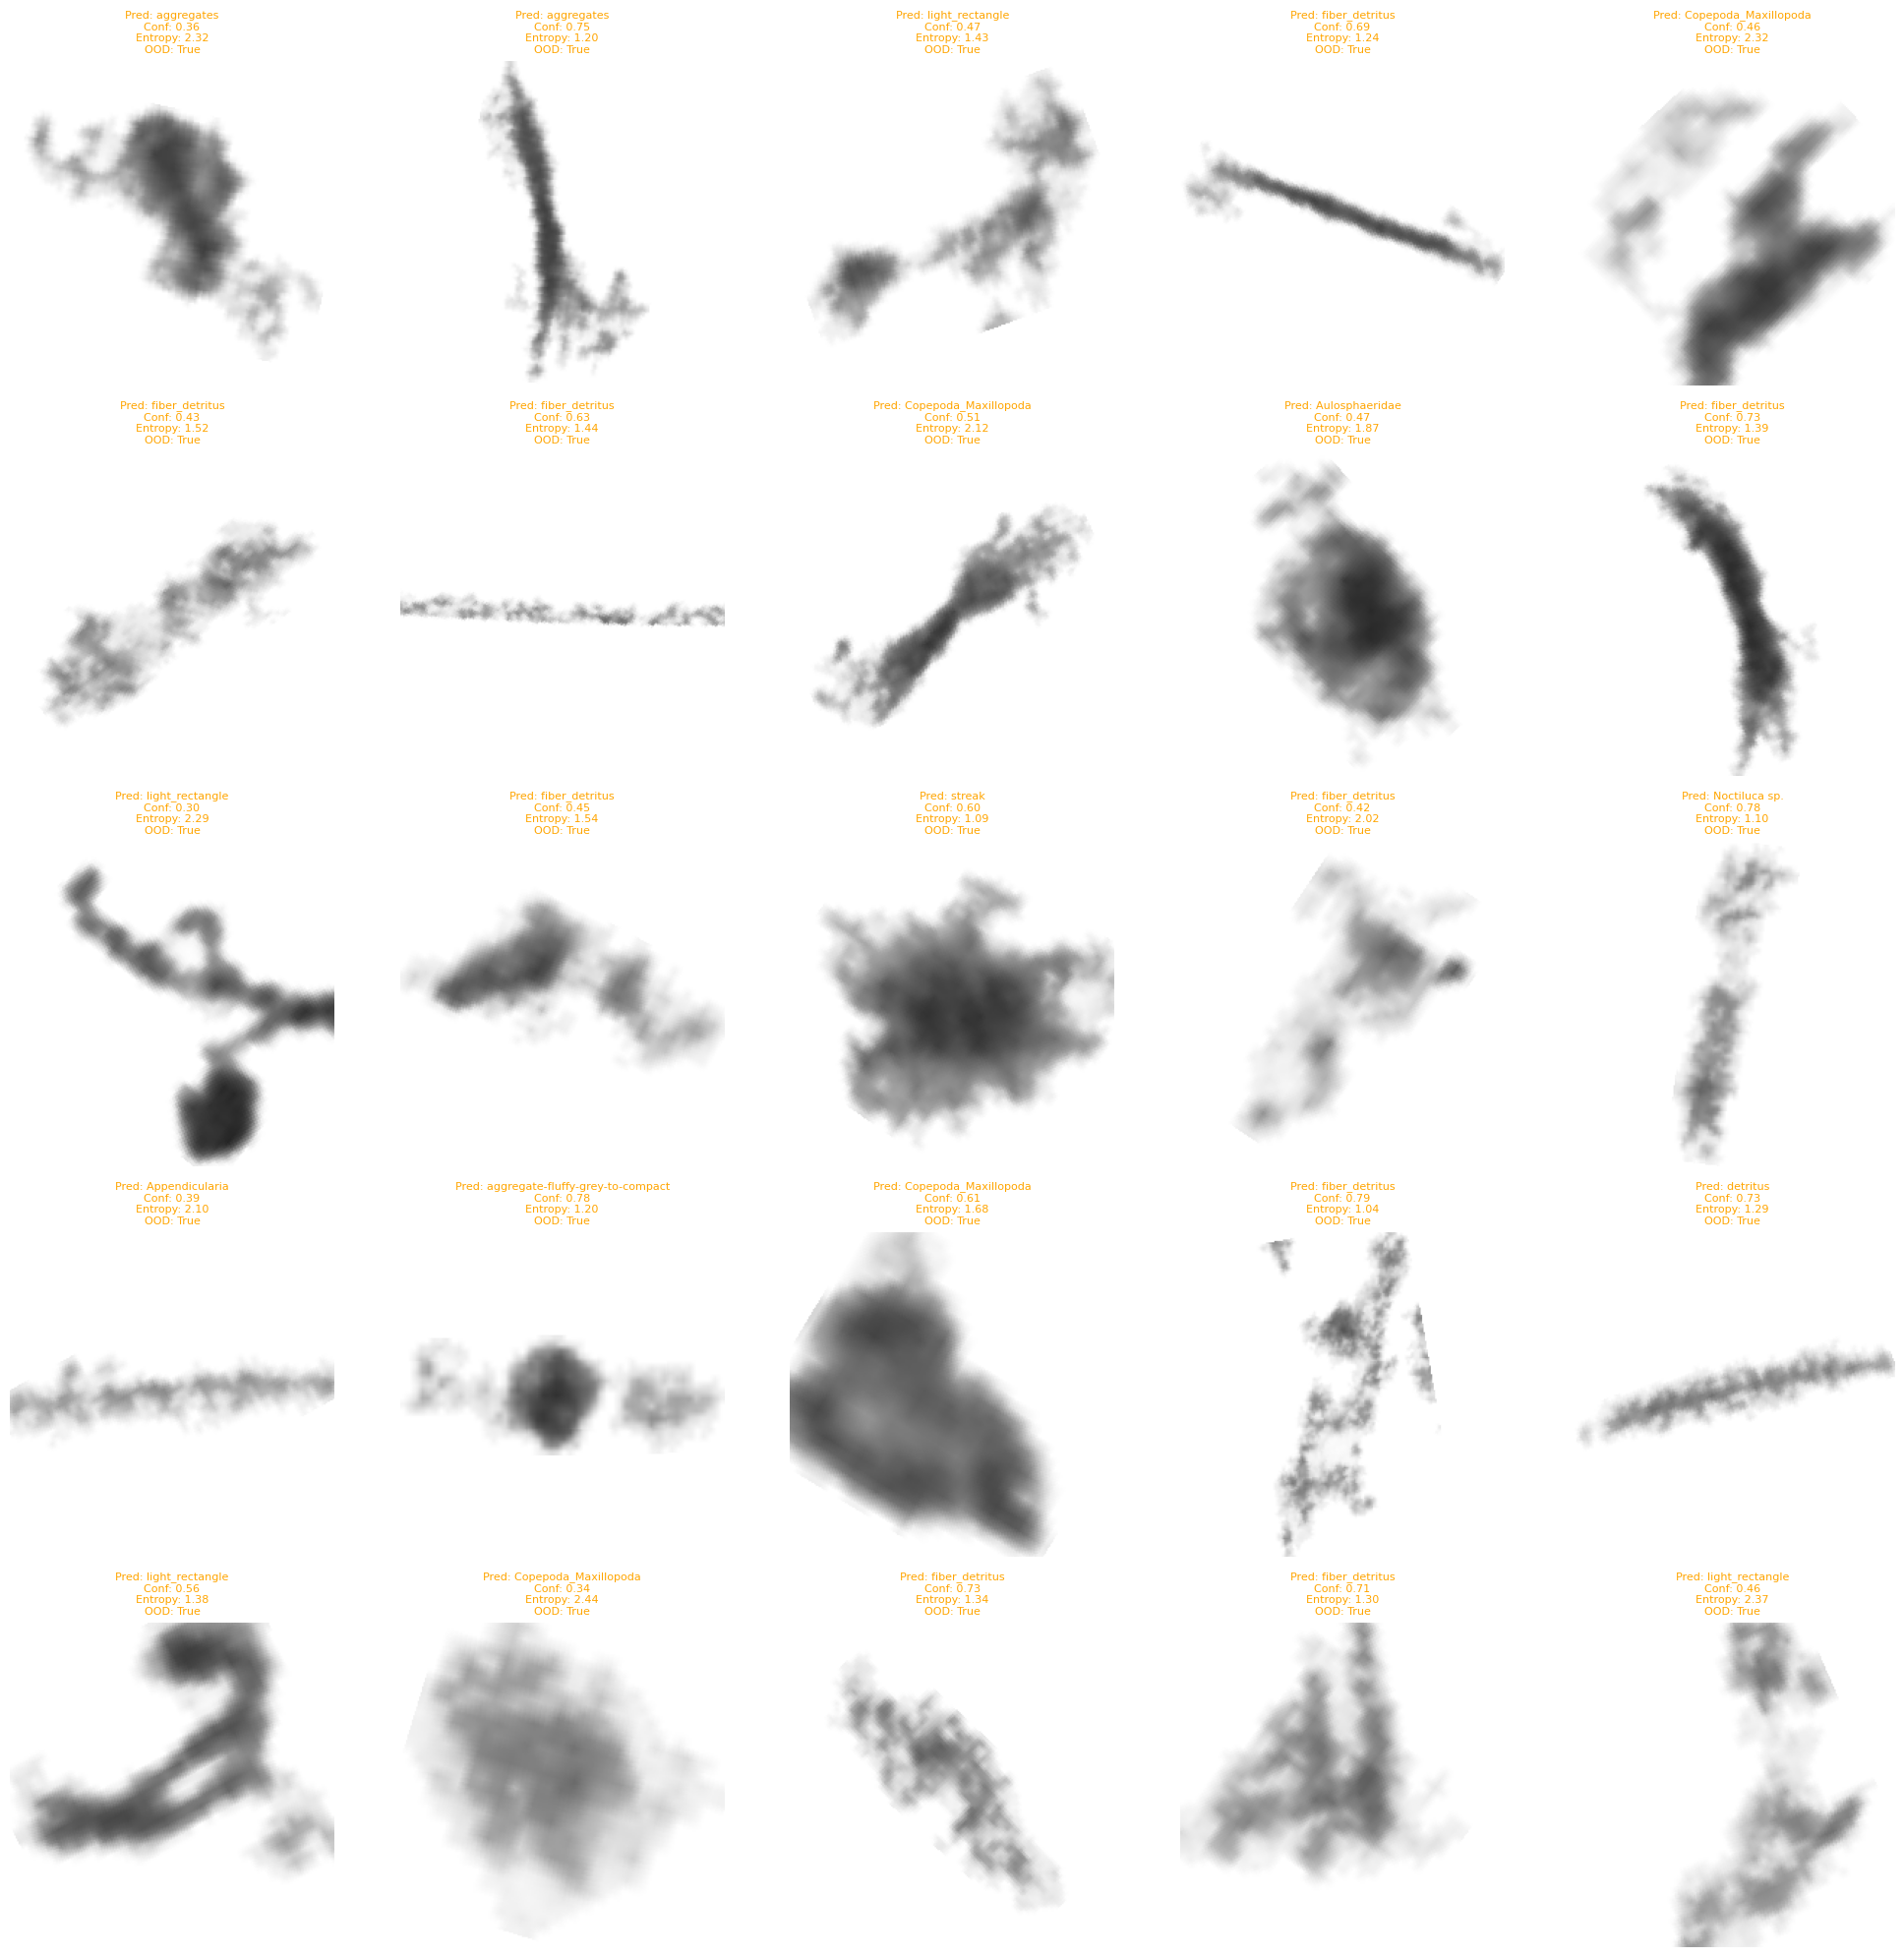


OOD Detection Summary:
Total samples: 105136
OOD samples: 40459 (38.5%)


In [67]:
def visualize_inference(dataset, predictions, probabilities, entropy_scores=None, ood_flags=None, num_samples=25, rows=5, cols=5, only_ood=False):
    """
    Visualize random samples with their predicted labels and confidence scores.
    
    Args:
        dataset: Dataset with transformed images
        predictions: List of predictions for each image
        probabilities: List of confidence scores
        entropy_scores: List of entropy scores for OOD detection
        ood_flags: List of boolean flags indicating OOD samples
        num_samples: Number of samples to visualize
        rows: Number of rows in the grid
        cols: Number of columns in the grid
        only_ood: If True, show only OOD samples
    """
    # Get indices of samples to display
    total_samples = len(dataset)
    if only_ood and ood_flags is not None:
        # Verify lengths match
        if ood_flags is not None and len(ood_flags) != total_samples:
            print(f"Warning: Length mismatch - dataset: {total_samples}, ood_flags: {len(ood_flags)}")
            total_samples = min(total_samples, len(ood_flags))  # Use shorter length
            # Get indices of OOD samples
        ood_indices = [i for i in range(total_samples) if ood_flags[i]]
        if not ood_indices:
            print("No OOD samples found!")
            return
        random_indices = random.sample(ood_indices, min(num_samples, len(ood_indices)))
    else:
        random_indices = random.sample(range(total_samples), min(num_samples, total_samples))
    
    # Adjust grid size based on number of samples
    actual_samples = len(random_indices)
    if actual_samples < num_samples:
        rows = int(np.ceil(np.sqrt(actual_samples)))
        cols = rows
    
    # Create a figure
    fig = plt.figure(figsize=(20, 20))
    
    for idx, sample_idx in enumerate(random_indices):
        # Get image and prediction
        sample = dataset[sample_idx]
        pred_label = predictions[sample_idx][0]  # Top prediction
        confidence = probabilities[sample_idx][0]  # Top confidence
        
        # Get OOD information
        ood_flag = ood_flags[sample_idx] if ood_flags is not None else False
        entropy = entropy_scores[sample_idx] if entropy_scores is not None else None
        
        # Create color for title based on OOD flag
        title_color = 'orange' if ood_flag else 'blue'
        
        # Plot the image
        plt.subplot(rows, cols, idx + 1)
        # Convert tensor to image for display
        img = sample['pixel_values'].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # Denormalize
        plt.imshow(img)
        
        # Add title with predicted label, confidence and OOD info
        title = f'Pred: {pred_label}\nConf: {confidence:.2f}'
        if entropy is not None:
            title += f'\nEntropy: {entropy:.2f}'
        title += f'\nOOD: {ood_flag}'
        
        plt.title(title, color=title_color, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if ood_flags is not None:
        total_ood = sum(ood_flags)
        print(f"\nOOD Detection Summary:")
        print(f"Total samples: {total_samples}")
        print(f"OOD samples: {total_ood} ({(total_ood/total_samples)*100:.1f}%)")

# Example usage:
print("\nVisualizing all samples:")
visualize_inference(ds_pisco_trans, predictions, probabilities, 
                   entropy_scores=entropy_scores, ood_flags=ood_flags)

print("\nVisualizing only OOD samples:")
visualize_inference(ds_pisco_trans, predictions, probabilities, 
                   entropy_scores=entropy_scores, ood_flags=ood_flags,
                   only_ood=True)